In [1]:
import logging
from dataclasses import asdict, dataclass
import numpy as np
import matplotlib as mpl
mpl.use("pgf")
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
from pprint import pformat
from copy import copy
import torch
import cv2
from contextlib import nullcontext
import numpy as np
from itertools import accumulate
import pandas as pd
import seaborn as sns

import tikzplotlib
#import roboticstoolbox as rtb

# from safetensors.torch import load_file, save_file
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.policies.factory import make_policy
from lerobot.common.robot_devices.control_configs import (
    ControlPipelineConfig,
    EvalControlConfig,
)
from lerobot.common.utils.utils import init_logging, get_safe_torch_device
from lerobot.configs import parser

def predict_action(observation, policy, device, use_amp):
    observation = copy(observation)
    with (
        torch.inference_mode(),
        torch.autocast(device_type=device.type) if device.type == "cuda" and use_amp else nullcontext(),
    ):
        # Convert to pytorch format: channel first and float32 in [0,1] with batch dimension
        for name in observation:
            if "image" in name:
                observation[name] = observation[name].type(torch.float32) / 255
                observation[name] = observation[name].permute(2, 0, 1).contiguous()
            observation[name] = observation[name].unsqueeze(0)
            observation[name] = observation[name].to(device)

        # Compute the next action with the policy
        # based on the current observation
        action = policy.select_action(observation)

        # Remove batch dimensifrom dataclasses import asdict, dataclasson
        action = action.squeeze(0)

        # Move to cpu, if not already the case
        action = action.to("cpu")

    return action
def get_episode_data_index(
    episode_dicts: dict[dict], episodes: list[int] | None = None
) -> dict[str, torch.Tensor]:
    episode_lengths = {ep_idx: ep_dict["length"] for ep_idx, ep_dict in episode_dicts.items()}
    if episodes is not None:
        episode_lengths = {ep_idx: episode_lengths[ep_idx] for ep_idx in episodes}

    cumulative_lengths = list(accumulate(episode_lengths.values()))
    return {
        "from": torch.LongTensor([0] + cumulative_lengths[:-1]),
        "to": torch.LongTensor(cumulative_lengths),
    }

# Forward kinematics function
def forward_kinematics(joint_angles,d,a,alpha):
    T = np.eye(4)
    #joint_angles[0] *= -1
    joint_angles_rad = np.radians(joint_angles)
    joint_angles_rad[1] -= 0.136
    joint_angles_rad[2] += 0.162
    joint_angles_rad[3] -= np.pi/2
    joint_angles_rad[4] *= -1 
    for i in range(5):
        theta = joint_angles_rad[i]
        ct, st = np.cos(theta), np.sin(theta)
        ca, sa = np.cos(alpha[i]), np.sin(alpha[i])
        Ti = np.array([
            [ct, -st * ca, st * sa, a[i] * ct],
            [st, ct * ca, -ct * sa, a[i] * st],
            [0, sa, ca, d[i]],
            [0, 0, 0, 1]
        ])
        T = T@Ti # Multiply transformation matrices

    yaw = np.degrees(np.arctan2(T[1, 0], T[0, 0]))
    return T[:3, 3],yaw#theta_tilt  # Extract position (x, y, z)

def compute_r2(q_d, q_a):
    mean_qd = np.mean(q_d)  # Mean of desired trajectory per joint
    sse = np.sum((q_d - q_a) ** 2)  # Sum of squared errors
    sst = np.sum((q_d - mean_qd) ** 2)  # Total variance
    r2 = 1 - (sse / sst)
    return r2

def get_grasps(episodes, episode_data_index, observations, d, a, alpha):
    obs_grasp = []
    grasp_angle= []
    for ep_idx in episodes:
        # Get the episode
        ep_start = int(episode_data_index["from"][ep_idx])
        ep_end = int(episode_data_index["to"][ep_idx])

        obs_set = observations[ep_start+30:ep_end]

        if len(obs_set) == 0:
            continue        

        grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 30), None)

        if grasp_idx is None:
            grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 40), None)

        fk, yaw = forward_kinematics(obs_set[grasp_idx][-6:],d,a,alpha)
        obs_grasp.append(fk)
        grasp_angle.append(yaw)


    obs_grasp = np.array(obs_grasp)
    grasp_angle = np.array(grasp_angle)
    return obs_grasp, grasp_angle

def get_averages(obs_grasp, grasp_angle, box_avg):
    avg_y = float(round(np.mean(obs_grasp[:, 1]),4))
    avg_x = float(round(np.mean(obs_grasp[:, 0]),4))
    avg_yaw = float(round(np.mean(grasp_angle[:]),4))
    avg_ep = [avg_x, avg_y, avg_yaw]

    ep_dx = obs_grasp[:, 0] - box_avg[0]
    ep_dy = obs_grasp[:, 1] - box_avg[1]
    d_norm = np.sqrt(ep_dx**2 + ep_dy**2)
    d_xy = [ep_dx,ep_dy,d_norm]

    avg_err_x = np.mean((ep_dx))
    avg_err_y = np.mean((ep_dy))
    avg_err_norm = np.mean(d_norm)
    avg_err = [avg_err_x, avg_err_y, avg_err_norm]

    std_x = np.std(obs_grasp[:, 0])
    std_y = np.std(obs_grasp[:, 1])
    std = [std_x, std_y]

    return avg_ep, d_xy, avg_err, std

d = [0.0563, 0.0, 0.0, 0.0, 0.05815]
a = [0.0, 0.10935, 0.10051, 0.0, 0.0]
alpha = [np.pi/2, np.pi, 0, -np.pi/2, 0]

b = 0.025
b_m = 0.025/2
o_g = 0.045 # Opening grasping position
o_g_e = o_g/2 - b_m # Opening grasping position error
w_g = 0.01 # Width grasping position
w_g_e = b_m - w_g/2 # Width grasping position error

# For plots

# Plot dimensions
lw = 6.29
aspect_ratio = 1.61803398875 
h = lw / aspect_ratio


plt.rcParams.update({
    "pgf.texsystem": "pdflatex",  # Or "xelatex" or "lualatex" depending on your LaTeX setup
    "text.usetex": True,         # Use LaTeX for all text rendering
    "font.family": "serif",      # Use serif font, typically matching LaTeX's default
    "font.serif": [],            # Clear specific serif fonts to let LaTeX choose
    "pgf.rcfonts": False,        # Don't setup fonts from rc parameters; let LaTeX handle them
    'mathtext.default': "regular",

    # Optional: Customize font sizes for better integration with your document
     "font.size": 12,
     "axes.labelsize": 12,
     "legend.fontsize": 12,
     "xtick.labelsize": 10,
     "ytick.labelsize": 10,
     "axes.titlesize": 16,
     "figure.titlesize": 20,
    
    # Figure size in inches (important for matching LaTeX document dimensions)
    # You might want to calculate this based on your LaTeX document's \textwidth
    "figure.figsize": (lw, h), # Example: Golden ratio for a single column
    

    
    # Custom preamble for LaTeX packages or commands
    "pgf.preamble": "\n".join([
        r"\usepackage[utf8x]{inputenc}",  # or utf8
        r"\usepackage[T1]{fontenc}",
        r"\usepackage{lmodern}",        # Example: Another font package
        # Add any other LaTeX packages you need for math, special symbols, etc.
        r"\usepackage{mathtools}",
        # r"\usepackage{amsfonts}",
        r"\usepackage{amssymb}",
        r"\providecommand{\mathdefault}[1]{#1}",
    ]),
    
})

colors = [
    "#e41a1c",  # Red
    "#377eb8",  # Blue
    "#4daf4a",  # Green
    "#984ea3",  # Purple
    "#ff7f00",  # Orange
    "#a65628",  # Brown
    "#66c2a5",  # Teal
    "#999999",  # Gray
    "#f781bf",  # Pink
    "#fc8d62",  # Coral
    "#8da0cb",  # Lavender
    "#e78ac3",  # Pinkish Purple
    "#a6d854",  # Lime Green
    "#ffd92f",  # Bright Yellow
    "#e5c494",  # Light Brown
    "#b3b3b3",  # Light Gray
    "#1b9e77",  # Dark Teal
    "#d95f02",  # Dark Orange
    "#7570b3",  # Indigo
    "#e7298a",  # Magenta
    "#66a61e",  # Olive Green
    "#e6ab02",  # Mustard
    "#a6761d",  # Golden Brown
    "#666666",  # Dark Gray
    "#b9db23",  # Yellow
    ]
    

c:\Users\nduqu\anaconda3\envs\lerobot_plot\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## E8 Plots ##

### Dataset plot ###

In [38]:

repo_id="nduque/robustness_e8_5"
repo_id="nduque/robustness_e8"

dataset = LeRobotDataset(repo_id)
observations = dataset.hf_dataset.select_columns("observation.state")['observation.state']
episodes = list(range(dataset.meta.total_episodes))
episode_data_index=get_episode_data_index(dataset.meta.episodes)

# Loop through dataset
#   Get observation (poses)
#   Save grasping position
#   Save observation, real action, predicted action in dictionary
obs_grasp = []
grasp_angle = []
for ep_idx in episodes:
    # Get the episode
    ep_start = int(episode_data_index["from"][ep_idx])
    ep_end = int(episode_data_index["to"][ep_idx])
    episode = dataset.hf_dataset

    obs_set = observations[ep_start+30:ep_end]
    if len(obs_set) == 0:
        continue        

    grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 30), None)

    if grasp_idx is None:
        grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 40), None)

    fk, yaw = forward_kinematics(obs_set[grasp_idx][-6:],d,a,alpha)
    obs_grasp.append(fk)
    grasp_angle.append(yaw)
obs_grasp = np.array(obs_grasp)

box_pos_avg_e8 = np.array([[ 0.1179,-0.0844, 4.2366],[ 0.1194, -0.0432, 5.4916],[ 0.1179, -0.0092, 6.4004],[ 0.1177, 0.0291, 2.7933],[ 0.1165, 0.0658, 1.3591]])
box_pos_avg_e8_5 = np.array([[0.1201, -0.076, 4.9085],[ 0.1199, -0.0373, 4.3924],[ 0.1198, -0.0012, 3.5846],[ 0.1211, 0.0374, 0.4634],[0.1217, 0.073, 0.0573]])

box_avg = box_pos_avg_e8

fig, axs = plt.subplots(1, 1, figsize=(lw, lw/2.5))

eps = int(len(episodes)/len(box_avg))
d_xy = []
avg_ep = []
for i in range(len(box_avg)):
    color=colors[i]

    box_pos = box_avg[i]
        
    avg_y = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 1]),4))
    avg_x = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 0]),4))
    avg_yaw = float(round(np.mean(grasp_angle[i*eps:(i+1)*eps]),4))
    avg_ep.append([avg_x, avg_y, avg_yaw])
    print([avg_x, avg_y, avg_yaw])
    ep_dx = obs_grasp[i*eps:(i+1)*eps, 0] - box_avg[i,0]
    ep_dy = obs_grasp[i*eps:(i+1)*eps, 1] - box_avg[i,1]
    d_xy.append([ep_dx,ep_dy])

    fc = color
    axs.scatter(obs_grasp[i*eps:(i+1)*eps, 1], obs_grasp[i*eps:(i+1)*eps, 0],color=color, fc=fc,s=20)
    axs.scatter(avg_y, avg_x, color=color, marker='x', s=100)

    bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
    rec = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3)
    axs.add_patch(rec)

    #axs.text(box_pos_avg_e8[i,0],box_pos_avg_e8[i,1]-0.004,str(dist_to_avg),ha='center')
d_xy = np.array(d_xy)

axs.set_xlabel("Horizontal Position [m]", fontsize=11)
axs.set_ylabel("Vertical Position [m]", fontsize=11)
axs.set_title("Grasping Position", fontsize = 12)
axs.set_aspect('equal')
axs.set_ylim(0.09,0.15)
axs.tick_params(axis='both', which='major', labelsize=10)
#axs.set_xlim(-0.1,0.1)

tikzplotlib.save("tikz/e8_dataset.tex")
fig.savefig('pgf/e8_dataset.pgf')

[0.1179, -0.0844, 4.2366]
[0.1194, -0.0432, 5.4916]
[0.1179, -0.0092, 6.4004]
[0.1177, 0.0291, 2.7933]
[0.1165, 0.0658, 1.3591]


### Evaluation plots ###

In [6]:
repos = ["nduque/eval_robustness_e8_no3_3_80k",
         "nduque/eval_robustness_e8_no3_3_100k_2",
         "nduque/eval_robustness_e8_no3_3_120k",
         "nduque/eval_robustness_e8_no3_3_140k",
         "nduque/eval_robustness_e8_no3_3_160k",
         "nduque/eval_robustness_e8_no3_3_180k",
         "nduque/eval_robustness_e8_no3_3_200k",
         "nduque/eval_robustness_e8_no3_3_220k",
         "nduque/eval_robustness_e8_no3_3_240k"]

success_3 = [[1,1,1,1,0],
           [0,1,1,1,1],
           [1,1,1,1,1],
           [0,0,1,1,1],
           [1,0,0,0,1],
           [0,1,1,0,0],
           [0,0,0,0,0],
           [0,0,0,0,0],
           [1,0,0,0,0]]

success_5 = [[0,0,0,0,0,0,0],
             [0,1,1,1,1],
             [1,1,1,1,1],
             [0,0,1,1,1],
             [1,0,0,0,1],
             [0,1,1,0,0],
             [0,0,0,0,0],
             [0,0,0,0,0],
             [1,0,0,0,0]]

titles = ["80k - 80%", "100k - 80%", "120k - 100%", "140k - 60%", "160k - 40%", "180k - 40%", "200k - 0%", "220k - 0%", "240k - 20%"]

cps = ['80k', '100k', '120k', '140k', '160k', '180k', '200k', '220k', '240k']

success = success_3
success_accum = np.sum(success, axis=1)/5 * 100

avg_ep = []
fig, axs = plt.subplots(3,3, figsize=(lw, lw))
d_xy = []
avg_err = []
total_grasp = []
for i,repo in enumerate(repos):
    

    dataset = LeRobotDataset(repo)
    observations = dataset.hf_dataset.select_columns("observation.state")['observation.state']
    episodes = list(range(dataset.meta.total_episodes))
    episode_data_index=get_episode_data_index(dataset.meta.episodes)
    eps_grasp = []
    eps_grasp_yaw = []

    box_avg = box_pos_avg_e8[2]
    eps = int(len(episodes)/len(box_avg))
    for j in range(len(episodes)):
        # Get the episode
        ep_start = int(episode_data_index["from"][episodes[j]])
        ep_end = int(episode_data_index["to"][episodes[j]])

        obs_set = observations[ep_start+30:ep_end]

        if len(obs_set) == 0:
            continue    
            
        grasp_idx = next((j for j, obs in enumerate(obs_set) if obs[-1] < 30), None)

        if grasp_idx is None:
            grasp_idx = next((j for j, obs in enumerate(obs_set) if obs[-1] < 40), None)

        fk, yaw = forward_kinematics(obs_set[grasp_idx][-6:],d,a,alpha)
        eps_grasp.append(fk)
        eps_grasp_yaw.append(yaw)

    cp_grasp = np.array(eps_grasp)
    cp_grasp_yaw = np.array(eps_grasp_yaw)
    total_grasp.append(cp_grasp[:5])

    color = colors[i]

    avg_y = float(round(np.mean(cp_grasp[:, 1]),4))
    avg_x = float(round(np.mean(cp_grasp[:, 0]),4))
    avg_yaw = float(round(np.mean(cp_grasp_yaw[:]),4))
    avg_ep.append([avg_x, avg_y, avg_yaw])
    #print([avg_x, avg_y, avg_yaw]) 

    ep_dx = cp_grasp[:, 0] - box_avg[0]
    ep_dy = cp_grasp[:, 1] - box_avg[1]
    d_norm = np.sqrt(ep_dx**2 + ep_dy**2)
    d_xy.append([ep_dx,ep_dy,d_norm])

    avg_err_x = np.mean((ep_dx))
    avg_err_y = np.mean((ep_dy))
    avg_err_norm = np.mean(d_norm)
    avg_err.append([avg_err_x, avg_err_y, avg_err_norm])


    for j in range(5):
        if success[i][j] == 0:
            fc = 'none'
        else:
            fc = color
        axs[i//3, i%3].scatter(cp_grasp[j,1], cp_grasp[j, 0],color=color, fc=fc)
 
    axs[i//3, i%3].scatter(avg_y, avg_x, color=color, marker='x', s=100)

    bottom_left = (box_avg[1]-0.0125,box_avg[0]-0.0125)
    rec = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_avg[2], rotation_point="center", linewidth=3)
    axs[i//3, i%3].add_patch(rec)
    axs[i//3, i%3].set_aspect('equal')
    axs[i//3, i%3].set_ylim(box_avg[0]-0.04,box_avg[0]+0.04)
    axs[i//3, i%3].set_xlim(box_avg[1]-0.05,box_avg[1]+0.05)
    axs[i//3, i%3].set_title(titles[i], fontsize=12)
    axs[i//3, i%3].set_xlabel('[m]', fontsize=11) 
    axs[i//3, i%3].set_ylabel('[m]', fontsize=11) 
    axs[i//3, i%3].tick_params(axis='both', which='major', labelsize=9)

success_marker = mlines.Line2D([], [], color='black', marker='o', markersize=6, label='Successful', fillstyle='full', linestyle='None')
unsuccess_marker = mlines.Line2D([], [], color='black', marker='o', markersize=6, label='Unsuccessful', fillstyle='none', linestyle='None')
average_marker = mlines.Line2D([], [], color='black', marker='x', markersize=6, label='Average', fillstyle='none', linestyle='None')

fig.legend(handles=[success_marker, unsuccess_marker,average_marker], loc='upper center', bbox_to_anchor=(0.52,0.94), fontsize=10, ncol=3)
fig.suptitle("Grasping attempts for test position per checkpoint", fontsize=14)
fig.subplots_adjust(wspace=0.25, hspace=0.25, top=0.8)
fig.tight_layout(rect=[0, 0, 1, 0.95])

fig.savefig('pgf/e8_grasping_positions.pgf')

fig_sr, axs_sr = plt.subplots(1,1, figsize=(lw, h))
axs_sr.plot(cps, success_accum, marker='o', color='black', label="Success Rate", linewidth=2, markersize=6)
axs_sr.set_title("Success rate per training checkpoint", fontsize=12)
axs_sr.set_xlabel('Training checkpoint', fontsize=11) 
axs_sr.set_ylabel('Success rate [%]', fontsize=11) 
axs_sr.tick_params(axis='both', which='major', labelsize=10)
fig_sr.tight_layout()
fig_sr.savefig('pgf/e8_success_rate.pgf')



In [7]:
fig2, axs2 = plt.subplots(3, 1, figsize=(lw, lw+0.1))
l_fs = 11
t_fs = 12

avg_ep = np.array(avg_ep)
avg_err = np.array(avg_err)
total_grasp = np.stack(total_grasp, axis=0)



for idx, label in enumerate(['vertical', 'horizontal']):
    axs2[idx].plot(avg_ep[:, idx], color=colors[1] if idx == 0 else colors[0], marker='o', linestyle='-', linewidth=2, markersize=5)
    axs2[idx].axhline(box_pos_avg_e8[1, idx], color=colors[3], marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 2')
    axs2[idx].axhline(box_avg[idx], color='green', marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 3')
    axs2[idx].axhline(box_pos_avg_e8[3, idx], color=colors[4], marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 4')
    axs2[idx].set_xticks(range(9), cps, fontsize=l_fs)
    axs2[idx].tick_params(axis='both', which='major', labelsize=10)
    axs2[idx].set_xlabel('Training checkpoint', fontsize=l_fs)
    axs2[idx].set_ylabel('Avg. position [m]', fontsize=l_fs)
    axs2[idx].set_title(f'Average {label} grasping position per training checkpoint', fontsize=t_fs)
    #axs2[idx].legend(fontsize=l_fs)
    boxplot_data = [arr[:,idx] for arr in total_grasp]
    axs2[idx].boxplot(boxplot_data, vert=True, labels=cps,positions = range(9))

axs2[2].plot(avg_err[:,0], color=colors[1], marker='o', linestyle='-', linewidth=2, markersize=5)
axs2[2].plot(np.abs(avg_err[:,1]), color=colors[0], marker='o', linestyle='-', linewidth=2, markersize=5)
axs2[2].axhline(0.0, color='green', marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 3')
axs2[2].set_xticks(range(9),cps, fontsize=l_fs)
axs2[2].tick_params(axis='both', which='major', labelsize=10)
axs2[2].set_xlabel('Training checkpoint', fontsize=l_fs)
axs2[2].set_ylabel('Abs. Avg. error [m]', fontsize=l_fs)
axs2[2].set_title('Abs. average grasping position error per training checkpoint', fontsize=t_fs)
#axs2[2].legend(fontsize=l_fs)

pos2_marker = mlines.Line2D([], [], color=colors[3], marker='o', markersize=6, label='Position 2', fillstyle='full', linestyle='--')
pos3_marker = mlines.Line2D([], [], color='green', marker='o', markersize=6, label='Position 3', fillstyle='full', linestyle='--')
pos4_marker = mlines.Line2D([], [], color=colors[4], marker='o', markersize=6, label='Position 4', fillstyle='full', linestyle='--')

fig2.tight_layout()

fig2.legend(handles=[pos2_marker, pos3_marker,pos4_marker], loc='upper center', bbox_to_anchor=(0.55,0.02), fontsize=10, ncol=3)


fig2.savefig('pgf/e8_avg_grasping_position.pgf', bbox_inches="tight", pad_inches=0.1)



In [40]:
# Read the CSV file
csv_train = pd.read_csv('csv/e8_5_no3_dp_train_loss.csv')
csv_val = pd.read_csv('csv/e8_5_no3_dp_val_loss.csv')
fig3, axs3 = plt.subplots(1, 2, figsize=(lw, lw/2))

x_vals = [0, 50e3, 100e3, 150e3, 200e3, 250e3, 300e3]
x_labels = ['0', '50k', '100k', '150k', '200k', '250k', '300k']
# Plot the dataframe
csv_train.plot(ax=axs3[0],x='Step', y='Train loss', color=colors[23])
csv_val.plot(ax=axs3[1],x='Step', y='Validation loss', color=colors[23])
axs3[0].set_ylabel('Train loss',fontsize=11)
axs3[1].set_ylabel('Validation loss',fontsize=11)
axs3[0].set_xlabel('Step', fontsize= 11)
axs3[1].set_xlabel('Step', fontsize=11)
axs3[0].set_title('Training loss',fontsize=12)
axs3[1].set_title('Validation loss',fontsize=12)

axs3[0].set_xticks(x_vals, x_labels)
axs3[0].tick_params(axis='both', which='major', labelsize=10)
axs3[0].legend().remove()
axs3[1].legend().remove()
axs3[1].set_xticks(x_vals, x_labels)
axs3[1].tick_params(axis='both', which='major', labelsize=10)

fig3.tight_layout()

fig3.savefig('pgf/e8_train_val_loss.pgf')

## E9 Plots ##
### Dataset plot ###

In [5]:
repo_id="nduque/robustness_e9_3"

known_mask = np.array([
    [True, False, True, False, True],
    [False, True, False, True, False],
    [True, False, True, False, True],
    [False, True, False, True, False],
    [True, False, True, False, True],
])

dataset = LeRobotDataset(repo_id)
observations = dataset.hf_dataset.select_columns("observation.state")['observation.state']
episodes = list(range(dataset.meta.total_episodes))
episode_data_index=get_episode_data_index(dataset.meta.episodes)

# Loop through dataset
#   Get observation (poses)
#   Save grasping position
#   Save observation, real action, predicted action in dictionary
obs_grasp = []
grasp_angle = []
for ep_idx in episodes:
    # Get the episode
    ep_start = int(episode_data_index["from"][ep_idx])
    ep_end = int(episode_data_index["to"][ep_idx])
    episode = dataset.hf_dataset

    obs_set = observations[ep_start+30:ep_end]
    if len(obs_set) == 0:
        continue        

    grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 30), None)

    if grasp_idx is None:
        grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 40), None)

    fk, yaw = forward_kinematics(obs_set[grasp_idx][-6:],d,a,alpha)
    obs_grasp.append(fk)
    grasp_angle.append(yaw)
    
obs_grasp = np.array(obs_grasp)

box_pos_avg_e9_3 = np.array([[0.193, -0.0786,  5.8925],[ 0.1898,-0.0009, 4.1929],[ 0.1957,0.0807, 1.2011],
                                 [ 0.1533,-0.0393, 5.8473],[ 0.1567,0.0353, 1.4479],[ 0.1211,-0.0746, 4.0604],
                                 [ 0.1188,-0.0025, 3.8189],[ 0.12,0.0722, 0.7847],[ 0.0861,-0.0396, 4.738],
                                 [ 0.0868,0.0366, -1.0705],[ 0.0526,-0.0696, 4.0597],[ 0.053,-0.0021, 1.3559],[ 0.0554,0.0694, -0.1613]])

box_avg = box_pos_avg_e9_3

fig, axs = plt.subplots(1, 1, figsize=(lw, lw))

eps = int(len(episodes)/len(box_avg))
d_xy_ds = []
avg_ep_ds = []
std_ds = []
for i in range(len(box_avg)):
    color=colors[i*2]

    box_pos = box_avg[i]
        
    avg_y = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 1]),4))
    avg_x = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 0]),4))
    avg_yaw = float(round(np.mean(grasp_angle[i*eps:(i+1)*eps]),4))
    avg_ep_ds.append([avg_x, avg_y, avg_yaw])
    #print([avg_x, avg_y, avg_yaw])
    ep_dx = obs_grasp[i*eps:(i+1)*eps, 0] - box_avg[i,0]
    ep_dy = obs_grasp[i*eps:(i+1)*eps, 1] - box_avg[i,1]
    d_xy_ds.append([ep_dx,ep_dy])

    std_x = np.std(obs_grasp[i*eps:(i+1)*eps, 0])
    std_y = np.std(obs_grasp[i*eps:(i+1)*eps, 1])
    std_ds.append([std_x, std_y])

    fc = color
    axs.scatter(obs_grasp[i*eps:(i+1)*eps, 1], obs_grasp[i*eps:(i+1)*eps, 0],color=color, fc=fc, s=13)
    axs.scatter(avg_y, avg_x, color=color, marker='x', s=70)

    bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
    rec = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3)
    axs.add_patch(rec)

    #axs.text(box_pos_avg_e8[i,0],box_pos_avg_e8[i,1]-0.004,str(dist_to_avg),ha='center')
d_xy_ds = np.array(d_xy_ds)

axs.set_xlabel("Horizontal [m]", fontsize=11)
axs.set_ylabel("Vertical [m]", fontsize=11)
axs.set_title("Grasping Position", fontsize=12)
axs.set_aspect('equal')
#axs.set_ylim(0.08,0.15)
axs.tick_params(axis='both', which='major', labelsize=10)
#axs.set_xlim(-0.1,0.1)

fig.savefig('pgf/e9_dataset.pgf')

annot_format=".4f"

std_ds_zip = np.zeros([25,2])
std_ds = np.array(std_ds)

std_ds_zip[::2] = std_ds
std_ds_zip[1::2] = np.zeros([12,2])
#print(std_ds_zip)

std_ds_zip= np.array(std_ds_zip).reshape(25, 2)
std_x = std_ds_zip[:,0].reshape(5, 5)
std_y = std_ds_zip[:,1].reshape(5, 5)



### Evaluation plots ###
#### Grasping plot + success rate heatmap full_dp_cluster_200k ####


In [15]:
repo_id="nduque/eval_robustness_e9_3_full_dp_cluster_200k"

box_pos_avg_e9_all = [[0.195,-0.0809,  8.8293],[0.1988,-0.0415,  8.2231],[ 0.1983,-0.0006, 6.3474],[ 0.1989, 0.0388, 4.407],[ 0.2004,0.0805, 2.3005],
                   [ 0.1543,-0.0758, 10.03],[ 0.1563,-0.0408, 8.1177],[ 0.1565,-0.0031, 9.1966],[ 0.1605,0.0378, 2.4887],[ 0.1588, 0.0759,3.1575],
                   [ 0.1187,-0.075, 6.3325],[ 0.12,-0.0374, 6.469],[ 0.1212,-0.0031, 5.7372],[ 0.1231,0.0338, 6.6873],[ 0.122,0.0757, 3.5465],
                   [ 0.0826,-0.0726, 5.5792],[ 0.0837,-0.0389, 5.1754],[ 0.0842,-0.0025, 3.2955],[ 0.0896,0.0345, 3.8578],[ 0.0891,0.071, 2.3324],
                   [ 0.0495,-0.0718, 2.1085],[ 0.0523,-0.0393, 5.1431],[0.0541,-0.0042,  3.0332],[ 0.0541,0.036, -1.2648],[ 0.057,0.0695, -1.611]]

success_e9_3_full_dp_cluster_200k = np.array([1,1,1,1,1,1,1, #1
                                                0,0,0,0,0,0,1, #2
                                                1,1,1,1,1,1,1, #3
                                                1,1,0,0,0,1,0, #4 --changed success of 25 (5th), because it didnt pick in first attempt
                                                1,1,1,1,1,1,1, #5
                                                0,0,0,0,0,0,0, #6
                                                1,1,1,1,1,1,1, #7
                                                1,1,1,1,1,1,1, #8
                                                1,1,1,1,1,1,1, #9
                                                1,0,1,1,1,1,1, #10
                                                1,1,1,1,1,1,1, #11
                                                1,0,0,1,0,0,0, #12 
                                                1,1,1,1,1,1,1, #13 
                                                0,0,0,0,0,0,1, #14
                                                1,1,1,1,1,1,1, #15
                                                1,1,1,1,1,1,1, #16
                                                1,1,1,1,1,1,1, #17
                                                1,1,1,1,1,1,1, #18
                                                1,1,1,1,1,1,1, #19
                                                1,1,1,1,1,1,1, #20
                                                1,1,1,1,1,1,1, #21
                                                0,0,0,0,0,0,0, #22
                                                1,1,1,1,1,1,1, #23
                                                0,0,0,0,0,0,0, #24
                                                1,1,1,1,1,1,1  #25
                                                ]) 
dataset = LeRobotDataset(repo_id)
observations = dataset.hf_dataset.select_columns("observation.state")['observation.state']
episodes = list(range(dataset.meta.total_episodes))
episode_data_index=get_episode_data_index(dataset.meta.episodes)

# Loop through dataset
#   Get observation (poses)
#   Save grasping position
#   Save observation, real action, predicted action in dictionary
obs_grasp = []
grasp_angle = []
total_grasp = []
for ep_idx in episodes:
    # Get the episode
    ep_start = int(episode_data_index["from"][ep_idx])
    ep_end = int(episode_data_index["to"][ep_idx])

    obs_set = observations[ep_start+30:ep_end]

    if len(obs_set) == 0:
        continue        

    grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 30), None)

    if grasp_idx is None:
        grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 40), None)

    fk, yaw = forward_kinematics(obs_set[grasp_idx][-6:],d,a,alpha)
    obs_grasp.append(fk)
    grasp_angle.append(yaw)


obs_grasp = np.array(obs_grasp)


fig, axs = plt.subplots(1, 2, figsize=(2*lw, lw))

box_pos_avg_e9_all = np.array(box_pos_avg_e9_all)
box_avg = box_pos_avg_e9_all
eps = int(len(episodes)/len(box_avg))

success = success_e9_3_full_dp_cluster_200k
success_accum = np.sum(success.reshape(25,7), axis=1)/7 * 100
eps = int(len(episodes)/len(box_avg))
d_xy = []
avg_ep = []
avg_err = []
std = []

for i in range(len(box_avg)):
    color=colors[i]

    box_pos = box_avg[i]
        
    avg_y = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 1]),4))
    avg_x = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 0]),4))
    avg_yaw = float(round(np.mean(grasp_angle[i*eps:(i+1)*eps]),4))
    avg_ep.append([avg_x, avg_y, avg_yaw])

    ep_dx = obs_grasp[i*eps:(i+1)*eps, 0] - box_avg[i,0]
    ep_dy = obs_grasp[i*eps:(i+1)*eps, 1] - box_avg[i,1]
    d_norm = np.sqrt(ep_dx**2 + ep_dy**2)
    d_xy.append([ep_dx,ep_dy,d_norm])

    avg_err_x = np.mean((ep_dx))
    avg_err_y = np.mean((ep_dy))
    avg_err_norm = np.mean(d_norm)
    avg_err.append([avg_err_x, avg_err_y, avg_err_norm])

    std_x = np.std(obs_grasp[i*eps:(i+1)*eps, 0])
    std_y = np.std(obs_grasp[i*eps:(i+1)*eps, 1])
    std.append([std_x, std_y])

    total_grasp.append(obs_grasp[i*eps:(i+1)*eps])

    fc = color
    for j in range(eps):
            if success[i*eps+j] == 0:
                fc = 'none'
            else:
                fc = color
            axs[0].scatter(obs_grasp[i*eps+j,1], obs_grasp[i*eps+j, 0],color=color, fc=fc, s=20)
    axs[0].scatter(avg_y, avg_x, color=color, marker='x', s=70)

    bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
    if known_mask[i//5, i%5]:
        rec = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3)
    else:
        rec = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3, linestyle='--')
    axs[0].add_patch(rec)


d_xy = np.array(d_xy)

axs[0].set_xlabel("Horizontal [m]", fontsize=22)
axs[0].set_ylabel("Vertical [m]", fontsize=22)
axs[0].tick_params(labelsize=20)
axs[0].set_title("Grasping Position", fontsize=24)
axs[0].set_aspect('equal')
#axs.set_ylim(0.04,0.22)
#axs.set_xlim(-0.1,0.1)

print(std)


success_accum = success_accum.reshape(5, 5)
success_accum = np.array(success_accum)

annot_format=".1f"

hm = sns.heatmap(success_accum, ax=axs[1], annot=True, fmt=annot_format, cmap="RdYlGn", cbar=True, linewidths=1,linecolor='black',vmin=0,vmax=100,square=True,cbar_kws={"shrink": 0.8})
cbar = hm.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

if known_mask is not None:
        for y in range(success_accum.shape[0]):
            for x in range(success_accum.shape[1]):
                if not known_mask[y, x]:
                    axs[1].add_patch(plt.Rectangle((x+0.05, y+0.05), 0.9, 0.9,fill=False, edgecolor='white',linestyle='--',lw=2))

axs[1].set_xlabel("Horizontal position", fontsize=22)
axs[1].set_ylabel("Vertical position", fontsize=22)
axs[1].set_title("Success Rate Per Position", fontsize=24)
axs[1].set_xticks([])
axs[1].set_yticks([])

success_marker = mlines.Line2D([], [], color='black', marker='o', markersize=6, label='Successful', fillstyle='full', linestyle='None')
unsuccess_marker = mlines.Line2D([], [], color='black', marker='o', markersize=6, label='Unsuccessful', fillstyle='none', linestyle='None')
average_marker = mlines.Line2D([], [], color='black', marker='x', markersize=6, label='Average', fillstyle='none', linestyle='None')
unknown_marker = mlines.Line2D([], [], color='black', marker='None', markersize=6, label='Unknown', fillstyle='none', linestyle='--')
fig.legend(handles=[success_marker, unsuccess_marker,average_marker, unknown_marker], loc='lower right', bbox_to_anchor=(0.915,-0.01), fontsize=18, ncol=2)
#fig.suptitle("Grasping attempts for test position", fontsize=20)
fig.tight_layout()

annot_format=".4f"
std= np.array(std).reshape(25, 2)
std_x = std[:,0].reshape(5, 5)
std_y = std[:,1].reshape(5, 5)

fig.savefig('pgf/e9_grasping_success.pgf', bbox_inches="tight", pad_inches=0.1)

annot_format=".4f"
std= np.array(std).reshape(25, 2)
std_x = std[:,0].reshape(5, 5)
std_y = std[:,1].reshape(5, 5)

[[0.00039876923605487377, 0.0016288401614837575], [0.004250751983794695, 0.010393457808717933], [0.001988418731101801, 0.004247405089658854], [0.005566358006158761, 0.01044757714119098], [0.0026938177101912637, 0.002838429051399032], [0.0033571986217400948, 0.0036025058125846547], [0.003582883676626998, 0.002160137758884054], [0.0040638058814099105, 0.0026704938464455702], [0.0018069803193325109, 0.004511644201002595], [0.003744402095229501, 0.006502276551505732], [0.0031482190355314613, 0.0013851756524948528], [0.004170258145214182, 0.0032011697020015543], [0.002227326948920697, 0.00083011665829639], [0.004697861392338295, 0.00407224999075165], [0.00327518824709015, 0.0023937615994005395], [0.007919562800835538, 0.0023221725172905936], [0.002598784150786974, 0.001236640849486637], [0.0031249482285361256, 0.0007813570710557433], [0.0017811413073231068, 0.0015162398879997622], [0.0039011331227763514, 0.0028330572911197324], [0.0007199209288310062, 0.0008860445037140784], [0.005439945587

#### Line plot of avg x,y for each position ####

In [12]:
fig2, axs2 = plt.subplots(2, 1, figsize=(2*lw, 2*lw/1.5))
l_fs = 22
t_fs = 24
lt_fs = 20

avg_ep = np.array(avg_ep)
avg_err = np.array(avg_err)
std = np.array(std)
std_ds = np.array(std_ds)

std_known_v = np.mean(std[::2,0])
std_known_h = np.mean(std[::2,1])
std_unknown_v = np.mean(std[1::2,0])
std_unknown_h = np.mean(std[1::2,1])

print(f"Std. known vertical: {std_known_v}, Std. known horizontal: {std_known_h}")
print(f"Std. unknown vertical: {std_unknown_v}, Std. unknown horizontal: {std_unknown_h}")

total_grasp = np.stack(total_grasp, axis=0)
print(total_grasp.shape)

pos = range(1, 26)

for idx, label in enumerate(['vertical', 'horizontal']):
    axs2[idx].plot(avg_ep[:, idx], color=colors[1] if idx == 0 else colors[0], marker='o', linestyle='-', linewidth=3, markersize=10, label='Avg. position')
    axs2[idx].plot(box_avg[:, idx], color=colors[1] if idx == 0 else colors[0], marker='x', linestyle='--', linewidth=3, markersize=15, label='Actual position')
    #axs2[idx].axhline(box_pos_avg_e8[1, idx], color=colors[3], marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 2')
    #axs2[idx].axhline(box_avg[idx], color='green', marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 3')
    #axs2[idx].axhline(box_pos_avg_e8[3, idx], color=colors[4], marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 4')
    axs2[idx].set_xticks(range(25), pos)
    axs2[idx].tick_params(axis='both', which='major', labelsize=lt_fs)
    axs2[idx].set_xlabel('Test position', fontsize=l_fs)
    axs2[idx].set_ylabel('Avg. position [m]', fontsize=l_fs)
    axs2[idx].set_title(f'Average {label} grasping position per test location', fontsize=t_fs)
    axs2[idx].legend(fontsize=lt_fs-2)
    boxplot_data = [arr[:,idx] for arr in total_grasp]
    #axs2[idx].boxplot(boxplot_data, vert=True, labels=pos,positions = range(25))
axs2[1].legend(fontsize=lt_fs-2, loc='upper left')
fig2.tight_layout()
fig2.savefig('pgf/e9_xy_grasping_positions.pgf')

fig2_err, axs2_err = plt.subplots(1, 1, figsize=(2*lw,2*h))

d_xy_reshape = d_xy.transpose(0,2,1).reshape(-1,3)
avg_err_x = np.mean(d_xy_reshape[:, 1])
avg_err_y = np.mean(d_xy_reshape[:, 0])
print(avg_err_x, avg_err_y)

axs2_err.plot(avg_err[:,0], color=colors[1], marker='o', linestyle='-', linewidth=3, markersize=10, label='Vertical error')
axs2_err.plot(avg_err[:,1], color=colors[0], marker='o', linestyle='-', linewidth=3, markersize=10, label='horizontal error')
#axs2_err.axhline(0.0, color='green', marker='o', linestyle='--', linewidth=2, markersize=5, label='Actual position')
axs2_err.axhline(avg_err_y, color=colors[1], marker='None', linestyle='--', linewidth=3, markersize=7, label='Avg. vertical error')
axs2_err.axhline(avg_err_x, color=colors[0], marker='None', linestyle='--', linewidth=3, markersize=7, label='Avg. horizontal error')
axs2_err.set_xticks(range(25),pos, fontsize=lt_fs)
axs2_err.tick_params(axis='both', which='major', labelsize=lt_fs)
axs2_err.set_xlabel('Test position', fontsize=l_fs)
axs2_err.set_ylabel('Avg. error [m]', fontsize=l_fs)
axs2_err.set_title('Average grasping position error per test location', fontsize=t_fs)
axs2_err.legend(fontsize=lt_fs)

fig2_err.tight_layout()
fig2_err.savefig('pgf/e9_avg_grasping_error.pgf')

fig3, axs3 = plt.subplots(2, 1, figsize=(2*lw, 2*lw/1.5))
ds_values = range(0,25,2)

axs3[1].plot(std[:,1], color=colors[0], marker='o', linestyle='-', linewidth=3, markersize=10, label='Std. dev. horizontal')
axs3[1].plot(ds_values, std_ds[:,1], color=colors[0], marker='x', linestyle='--', linewidth=3, markersize=15, label='Dataset Std. dev. horizontal')

axs3[1].set_xticks(range(25),pos)
axs3[1].tick_params(axis='both', which='major', labelsize=lt_fs)
axs3[1].set_xlabel('Test position', fontsize=l_fs)
axs3[1].set_ylabel('Std. dev', fontsize=l_fs)
axs3[1].set_title('Average grasping position horizontal standard deviation', fontsize=t_fs)
axs3[1].legend(fontsize=lt_fs)

axs3[0].plot(std[:,0], color=colors[1], marker='o', linestyle='-', linewidth=3, markersize=10, label='Std. dev. vertical')
axs3[0].plot(ds_values,std_ds[:,0], color=colors[1], marker='x', linestyle='--', linewidth=3, markersize=15, label='Dataset Std. dev. vertical')

axs3[0].set_xticks(range(25),pos)
axs3[0].tick_params(axis='both', which='major', labelsize=lt_fs)
axs3[0].set_xlabel('Training checkpoint', fontsize=l_fs)
axs3[0].set_ylabel('Std. dev', fontsize=l_fs)
axs3[0].set_title('Average grasping position vertical standard deviation', fontsize=t_fs)
axs3[0].legend(fontsize=lt_fs)

fig3.tight_layout()
fig3.savefig('pgf/e9_error_std_general.pgf')


Std. known vertical: 0.002213900696117297, Std. known horizontal: 0.002024204528561995
Std. unknown vertical: 0.004283893057218027, Std. unknown horizontal: 0.005806887925915195
(25, 7, 3)
2.739804719267396e-05 0.0025869581083694773


#### Error histogram ####

In [16]:
import pandas as pd

# Define bin width
bin_width = 0.005
########## GENERAL ERROR ANALYSIS ##########
bins = np.arange(-0.04, 0.04+bin_width, bin_width)

d_xy_reshape = d_xy.transpose(0,2,1).reshape(-1,3)
avg_err_x = np.mean(d_xy_reshape[:, 1])
avg_err_y = np.mean(d_xy_reshape[:, 0])
avg_err = round(np.mean(np.linalg.norm(d_xy_reshape, axis=1)),3)

avg_err_x_success = np.mean(d_xy_reshape[success == 1, 1])
avg_err_y_success = np.mean(d_xy_reshape[success == 1, 0])
avg_err_success = round(np.mean(np.linalg.norm(d_xy_reshape[success == 1], axis=1)),3)

avg_err_x_failed = np.mean(d_xy_reshape[success == 0, 1])
avg_err_y_failed = np.mean(d_xy_reshape[success == 0, 0]) 
avg_err_failed = round(np.mean(np.linalg.norm(d_xy_reshape[success == 0], axis=1)),3)

fig_gea, axs_gea = plt.subplots(1,2, figsize=(2*lw, lw))

#axs8[0].hist(d_k_uk_x, bins=bins, label=['Known', 'known'], stacked=False, color=colors[6:8])

t_fs = 24
l_fs = 22
lt_fs = 20


axs_gea[0].hist([d_xy[:,1,:].flatten()[success == 1],d_xy[:,1,:].flatten()[success == 0]],label=['Successful','Failed'], color=[colors[1], colors[0]], stacked = True, bins=bins)
axs_gea[0].set_title("Horizontal error histogram - all tests", fontsize=t_fs)
axs_gea[0].axvline(0.0125, color='green', linestyle='--', label='Block limits',linewidth=3)
axs_gea[0].axvline(-0.0125, color='green', linestyle='--', linewidth=3)
axs_gea[0].axvline(avg_err_x, color='black', linestyle='--', linewidth=3, label='Avg. err: ' + str(round(avg_err_x,4)) + ' m')
axs_gea[0].legend(fontsize=15, loc='upper left')
axs_gea[0].set_ylabel("Count", fontsize=l_fs)
axs_gea[0].set_xlabel("Horizontal error [m]", fontsize=l_fs)
axs_gea[0].tick_params(labelsize=lt_fs)

axs_gea[1].hist([d_xy[:,0,:].flatten()[success == 1],d_xy[:,0,:].flatten()[success == 0]], orientation='horizontal',label=['Successful','Failed'], color=[colors[1], colors[0]], stacked = True, bins=bins)
axs_gea[1].set_title("Vertical error histogram - all tests", fontsize=t_fs)
axs_gea[1].axhline(0.0125, color='green', linestyle='--', label='Block limits', linewidth=3)
axs_gea[1].axhline(-0.0125, color='green', linestyle='--', linewidth=3)
axs_gea[1].axhline(avg_err_y, color='black', linestyle='--', linewidth=3, label='Avg. err: ' + str(round(avg_err_y,4)) + ' m')
axs_gea[1].legend(fontsize=15)
axs_gea[1].tick_params(labelsize=lt_fs)
axs_gea[1].set_xlabel("Count", fontsize=l_fs)
axs_gea[1].set_ylabel("Vertical error [m]", fontsize= l_fs)

fig_gea.tight_layout()
fig_gea.savefig('pgf/e9_general_error_hist.pgf')

bottom_left = (-0.0125, -0.0125)
fig_gea_scatter, axs_gea_scatter = plt.subplots(1, 1, figsize=(2*lw, 2*lw-3))
rec_u = plt.Rectangle(bottom_left,0.025,0.025, ec='green', fc='none', rotation_point="center", linewidth=4, linestyle=':', label='Block')
axs_gea_scatter.add_patch(rec_u)
axs_gea_scatter.axvline(0.0, color=colors[7], linestyle='--', linewidth = 3)
axs_gea_scatter.axhline(0.0, color=colors[7], linestyle='--', linewidth = 3)

axs_gea_scatter.scatter(d_xy_reshape[success == 0,1], d_xy_reshape[success == 0,0], color=colors[0], s = 30)
axs_gea_scatter.scatter(d_xy_reshape[success == 1,1], d_xy_reshape[success ==1,0], color=colors[1], s = 30)
axs_gea_scatter.scatter(avg_err_x, avg_err_y, marker='X', s=200, color='white', edgecolors= 'black', label='Average Error: '+str(avg_err) + ' m')

axs_gea_scatter.scatter(avg_err_x_success, avg_err_y_success, marker='X', s=200, color=colors[1], edgecolors= 'black' ,label='Avg. Error success: '+str(avg_err_success) + ' m')
axs_gea_scatter.scatter(avg_err_x_failed, avg_err_y_failed, marker='X', s=200, color=colors[0], edgecolors= 'black', label='Avg. Error, failure: '+str(avg_err_failed) + ' m')

axs_gea_scatter.legend(fontsize = lt_fs)
axs_gea_scatter.set_title("2D error scatter - all tests",fontsize=t_fs)
axs_gea_scatter.set_xlabel("Horizontal error [m]", fontsize=l_fs)
axs_gea_scatter.set_ylabel("Vertical error [m]", fontsize= l_fs)
axs_gea_scatter.tick_params(labelsize=lt_fs)

axs_gea_scatter.set_xlim(-0.035, 0.035)
axs_gea_scatter.set_ylim(-0.025, 0.025)

axs_gea_scatter.set_aspect('equal')
fig_gea_scatter.tight_layout()
fig_gea_scatter.savefig('pgf/e9_error_scatter_general.pgf')


### Counting by quadrants

total_q1_g = np.sum((d_xy_reshape[:, 1] < 0) & (d_xy_reshape[:, 0] > 0))
total_q2_g = np.sum((d_xy_reshape[:, 1] > 0) & (d_xy_reshape[:, 0] > 0))
total_q3_g = np.sum((d_xy_reshape[:, 1] < 0) & (d_xy_reshape[:, 0] < 0))
total_q4_g = np.sum((d_xy_reshape[:, 1] > 0) & (d_xy_reshape[:, 0] < 0))

success_q1_g = np.sum((d_xy_reshape[success==1, 1] < 0) & (d_xy_reshape[success==1, 0] > 0))
success_q2_g = np.sum((d_xy_reshape[success==1, 1] > 0) & (d_xy_reshape[success==1, 0] > 0))
success_q3_g = np.sum((d_xy_reshape[success==1, 1] < 0) & (d_xy_reshape[success==1, 0] < 0))
success_q4_g = np.sum((d_xy_reshape[success==1, 1] > 0) & (d_xy_reshape[success==1, 0] < 0))

failed_q1_g = np.sum((d_xy_reshape[success==0, 1] < 0) & (d_xy_reshape[success==0, 0] > 0))
failed_q2_g = np.sum((d_xy_reshape[success==0, 1] > 0) & (d_xy_reshape[success==0, 0] > 0))
failed_q3_g = np.sum((d_xy_reshape[success==0, 1] < 0) & (d_xy_reshape[success==0, 0] < 0))
failed_q4_g = np.sum((d_xy_reshape[success==0, 1] > 0) & (d_xy_reshape[success==0, 0] < 0))


data = {
    "Quadrant": ["Q1 (-x,+y)", "Q2 (+x,+y)", "Q3 (-x,-y)", "Q4 (+x,-y)"],
    "Total": [total_q1_g, total_q2_g, total_q3_g, total_q4_g],
    "Success": [success_q1_g, success_q2_g, success_q3_g, success_q4_g],
    "Failed": [failed_q1_g, failed_q2_g, failed_q3_g, failed_q4_g]
}
df_quadrants = pd.DataFrame(data)
print(df_quadrants.to_string(index=False))


  Quadrant  Total  Success  Failed
Q1 (-x,+y)     51       36      15
Q2 (+x,+y)     49       31      18
Q3 (-x,-y)     37       28       9
Q4 (+x,-y)     38       37       1


C:\Users\nduqu\AppData\Local\Temp\ipykernel_25524\2657265513.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_gea_scatter, axs_gea_scatter = plt.subplots(1, 1, figsize=(2*lw, 2*lw-3))


Pos:  [ 26 108 111 116]
Closest unsuccessful:  93  -  0.013869080931369574
farthest_unsuccessful:  149  -  0.03653584887061855
mean unsuccessful:  0.0014220087720108582
closest successful:  52  -  6.6478109210112e-05
farthest successful:  77  -  0.015831130299405517
mean successful:  0.005479755851634425


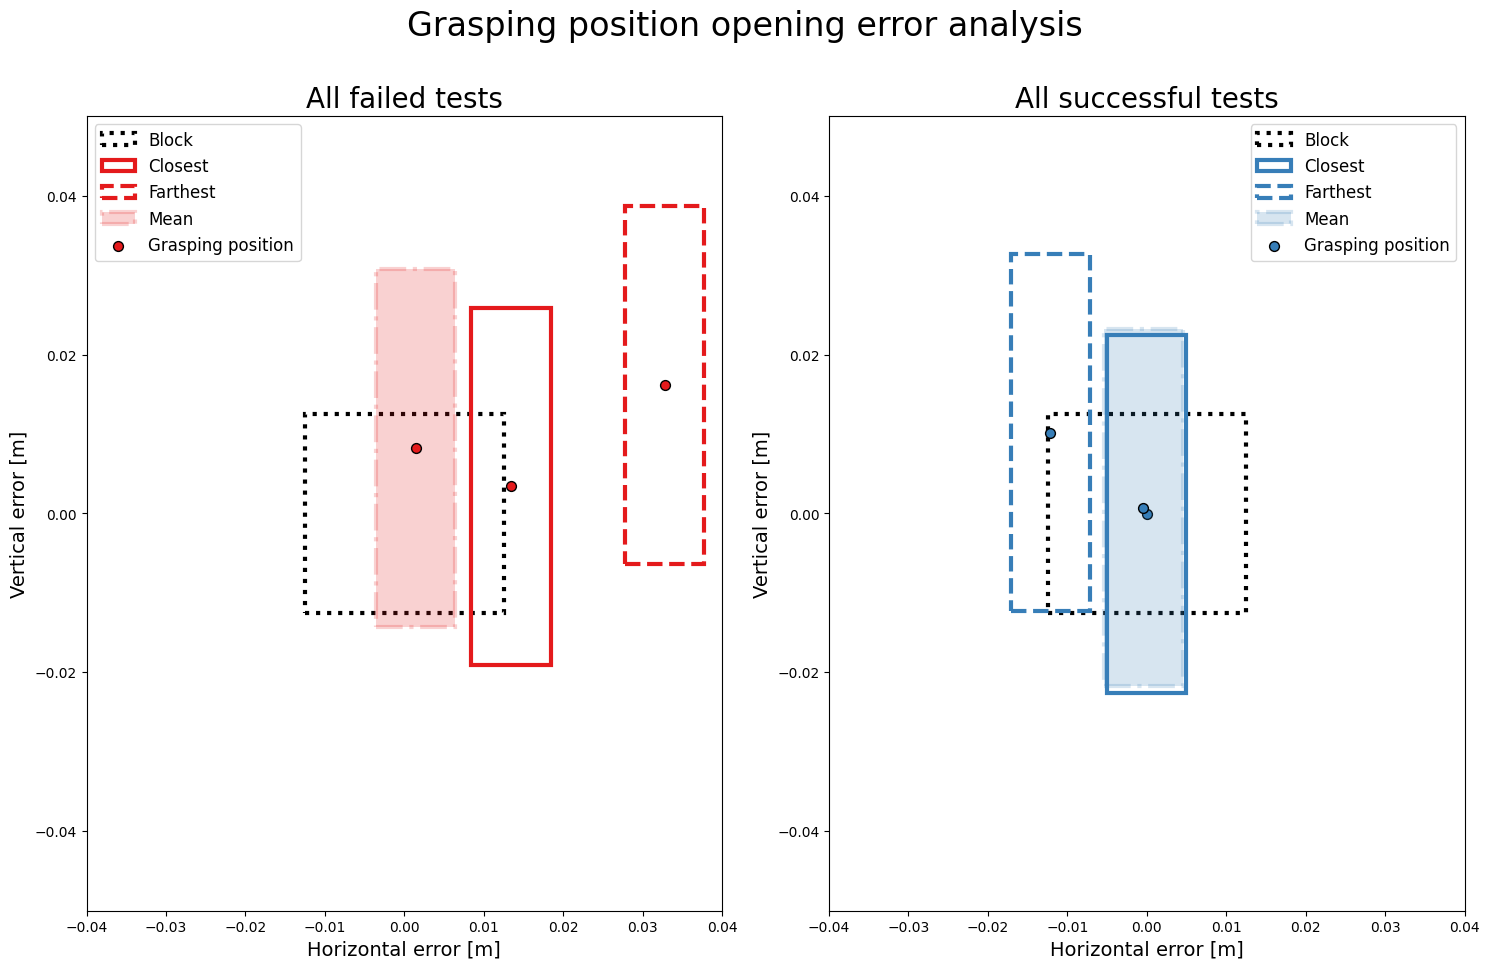

In [ ]:
fig_gea_opening, axs_gea_opening = plt.subplots(1, 2, figsize=(2*lw, 2*lw/1.5))


box_pos = [0,0]
bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
rec_u = plt.Rectangle(bottom_left,0.025,0.025, ec='black', fc='none', rotation_point="center", linewidth=3, linestyle=':', label='Block')
axs_gea_opening[0].add_patch(rec_u)
rec_s = plt.Rectangle(bottom_left,0.025,0.025, ec='black', fc='none', rotation_point="center", linewidth=3, linestyle=':',label='Block')
axs_gea_opening[1].add_patch(rec_s)

failed_inside_x = abs(d_xy_reshape[success == 1, 1]) > 0.0125
failed_inside_y = abs(d_xy_reshape[success == 1, 0]) > 0.0125
failed_inside_tot = failed_inside_y | failed_inside_x

#print("Failed_x:", failed_inside_x)
#print("Failed_y:", failed_inside_y)
#print("Failed_tot:", failed_inside_tot)


print("Pos: ",np.where(success == 1)[0][failed_inside_tot])


# Closest unsuccessful
cu = np.argmin(d_xy_reshape[success == 0,2])
closest_unsuccessful = d_xy_reshape[success == 0,:][cu]
print("Closest unsuccessful: ",np.where(success == 0)[0][cu]," - ",closest_unsuccessful[2])
rec_min_unsuccessful = plt.Rectangle((closest_unsuccessful[1]-0.005, closest_unsuccessful[0]-0.0225), 0.01, 0.045, ec=colors[0], fc='none', rotation_point="center", linewidth=3, label='Closest', linestyle='-')
axs_gea_opening[0].add_patch(rec_min_unsuccessful)
axs_gea_opening[0].scatter(closest_unsuccessful[1], closest_unsuccessful[0], marker='o', s=50, color=colors[0], edgecolors='black')

# Farthest unsuccessful
fu = np.argmax(d_xy_reshape[success == 0,2])
farthest_unsuccessful = d_xy_reshape[success == 0,:][fu]
print("farthest_unsuccessful: ",np.where(success == 0)[0][fu]," - " , farthest_unsuccessful[2])
rec_max_unsuccessful = plt.Rectangle((farthest_unsuccessful[1]-0.005, farthest_unsuccessful[0]-0.0225), 0.01, 0.045, ec=colors[0], fc='none', rotation_point="center", linewidth=3, label='Farthest', linestyle='--')
axs_gea_opening[0].add_patch(rec_max_unsuccessful)
axs_gea_opening[0].scatter(farthest_unsuccessful[1], farthest_unsuccessful[0], marker='o', s=50, color=colors[0], edgecolors='black')

# mean_unsuccessful = np.mean(d_xy_reshape[success == 0,2])
mean_unsuccessful = np.mean(d_xy_reshape[success == 0,1])
print("mean unsuccessful: ", mean_unsuccessful)
rec_mean_unsuccessful = plt.Rectangle((avg_err_x_failed-0.005, avg_err_y_failed-0.0225), 0.01, 0.045, ec=colors[0], fc=colors[0],alpha=0.2, rotation_point="center", linewidth=3,linestyle='-.', label='Mean')
axs_gea_opening[0].add_patch(rec_mean_unsuccessful)
axs_gea_opening[0].scatter(avg_err_x_failed, avg_err_y_failed, marker='o', s=50, color=colors[0], edgecolors='black', label='Grasping position')

axs_gea_opening[0].set_aspect('equal')
axs_gea_opening[0].set_xlim(-0.04, 0.04)
axs_gea_opening[0].set_ylim(-0.05, 0.05)

axs_gea_opening[0].set_title("All failed tests",fontsize=t_fs)
axs_gea_opening[0].set_xlabel("Horizontal error [m]", fontsize=l_fs)
axs_gea_opening[0].set_ylabel("Vertical error [m]", fontsize= l_fs)
axs_gea_opening[0].tick_params(labelsize=lt_fs)

axs_gea_opening[0].legend(fontsize=lt_fs)

# Closest successful
cs = np.argmin(d_xy_reshape[success == 1,2])
closest_successful = d_xy_reshape[success == 1,:][cs]
print("closest successful: ",np.where(success == 1)[0][cs]," - " , closest_successful[2])
rec_min_successful = plt.Rectangle((closest_successful[1]-0.005, closest_successful[0]-0.0225), 0.01, 0.045, ec=colors[1], fc='none', rotation_point="center", linewidth=3, label='Closest', linestyle='-')
axs_gea_opening[1].add_patch(rec_min_successful)
axs_gea_opening[1].scatter(closest_successful[1], closest_successful[0], marker='o', s=50, color=colors[1], edgecolors='black')

# Farthest successful
fs = np.argmax(d_xy_reshape[success == 1,2])
farthest_successful = d_xy_reshape[success == 1,:][fs]
print("farthest successful: ",np.where(success == 1)[0][fs], " - " ,farthest_successful[2])
rec_max_successful = plt.Rectangle((farthest_successful[1]-0.005, farthest_successful[0]-0.0225), 0.01, 0.045, ec=colors[1], fc='none', rotation_point="center", linewidth=3, label='Farthest',linestyle='--')
axs_gea_opening[1].add_patch(rec_max_successful)
axs_gea_opening[1].scatter(farthest_successful[1], farthest_successful[0], marker='o', s=50, color=colors[1], edgecolors='black')

# mean successful
mean_successful = np.mean(d_xy_reshape[success == 1,2])
print("mean successful: ", mean_successful)
rec_mean_successful = plt.Rectangle((avg_err_x_success-0.005, avg_err_y_success-0.0225), 0.01, 0.045, ec=colors[1], fc=colors[1], alpha = 0.2, rotation_point="center", linewidth=3,linestyle='-.', label='Mean')
axs_gea_opening[1].add_patch(rec_mean_successful)
axs_gea_opening[1].scatter(avg_err_x_success, avg_err_y_success, marker='o', s=50, color=colors[1], edgecolors='black', label='Grasping position')


axs_gea_opening[1].set_aspect('equal')
axs_gea_opening[1].set_xlim(-0.04, 0.04)
axs_gea_opening[1].set_ylim(-0.05, 0.05)

axs_gea_opening[1].set_title("All successful tests",fontsize=t_fs)
axs_gea_opening[1].set_xlabel("Horizontal error [m]", fontsize=l_fs)
axs_gea_opening[1].set_ylabel("Vertical error [m]", fontsize= l_fs)
axs_gea_opening[1].tick_params(labelsize=lt_fs)

axs_gea_opening[1].legend(fontsize=lt_fs)

fig_gea_opening.suptitle("Grasping position opening error analysis", fontsize=26)
fig_gea_opening.tight_layout()
fig_gea_opening.savefig('pgf/e9_error_opening.pgf')

In [27]:
############known ERROR ANALYSIS############
# Define bin width
bins = np.arange(-0.04, 0.04+bin_width, bin_width)
d_xy_unknown = d_xy[1::2,:,:]  # Select every second episode (unknown)
d_xy_reshape = d_xy_unknown.transpose(0,2,1).reshape(-1, 3)
succ_reshaped = success.reshape(-1, 7)
selected_groups = succ_reshaped[1::2]
succ_unknown = selected_groups.reshape(-1)

avg_err_x_unknown = np.mean(d_xy_reshape[:, 1])
avg_err_y_unknown = np.mean(d_xy_reshape[:, 0])
avg_err_unknown = round(np.mean(np.linalg.norm(d_xy_reshape, axis=1)),3)

avg_err_x_succ_unknown = np.mean(d_xy_reshape[succ_unknown == 1, 1])
avg_err_y_succ_unknown = np.mean(d_xy_reshape[succ_unknown == 1, 0])
avg_err_succ_unknown = round(np.mean(np.linalg.norm(d_xy_reshape[succ_unknown == 1], axis=1)),3)

avg_err_x_failed_unknown = np.mean(d_xy_reshape[succ_unknown == 0, 1])
avg_err_y_failed_unknown = np.mean(d_xy_reshape[succ_unknown == 0, 0]) 
avg_err_failed_unknown = round(np.mean(np.linalg.norm(d_xy_reshape[succ_unknown == 0], axis=1)),3)

t_fs = 24
l_fs = 22
lt_fs = 20

fig_uea, axs_uea = plt.subplots(1,2, figsize=(2*lw, lw))

d_x_known_hist = [d_xy_unknown[:,1,:].flatten()[succ_unknown == 1], d_xy_unknown[:,1,:].flatten()[succ_unknown == 0]]
axs_uea[0].hist(d_x_known_hist,label=['Successful','Failed'], color=[colors[1], colors[0]], stacked = True, bins=bins)
axs_uea[0].set_title("Horizontal error histogram - unknown tests", fontsize=t_fs)
axs_uea[0].axvline(0.0125, color='green', linestyle='--', label='Block limits',linewidth=3)
axs_uea[0].axvline(-0.0125, color='green', linestyle='--', linewidth=3)
axs_uea[0].axvline(avg_err_x_unknown, color='black', linestyle='--', label='Avg. err: ' + str(round(avg_err_x_unknown,4)) + ' m', linewidth=3)
axs_uea[0].legend(fontsize=15, loc='upper right')

d_y_known_hist = [d_xy_unknown[:,0,:].flatten()[succ_unknown == 1], d_xy_unknown[:,0,:].flatten()[succ_unknown == 0]]
axs_uea[1].hist(d_y_known_hist,label=['Successful','Failed'], color=[colors[1], colors[0]], stacked = True, bins=bins, orientation='horizontal')
axs_uea[1].set_title("Vertical error histogram - unknown tests", fontsize=t_fs)
axs_uea[1].axhline(0.0125, color='green', linestyle='--', label='Block limits', linewidth=3)
axs_uea[1].axhline(-0.0125, color='green', linestyle='--', linewidth=3)
axs_uea [1].axhline(avg_err_y_unknown, color='black', linestyle='--', label='Avg. err: ' + str(round(avg_err_y_unknown,4)) + ' m', linewidth=3)
axs_uea[1].legend(fontsize=15)

axs_uea[0].set_xlabel("Horizontal error [m]", fontsize=l_fs)
axs_uea[0].set_ylabel("Count", fontsize=l_fs)
axs_uea[0].tick_params(labelsize=lt_fs)

axs_uea[1].set_ylabel("Vertical error [m]", fontsize=l_fs)
axs_uea[1].set_xlabel("Count", fontsize=l_fs)
axs_uea[1].tick_params(labelsize=lt_fs)

fig_uea.tight_layout()
fig_uea.savefig('pgf/e9_unknown_error_hist.pgf')

print("Avg. error x unknown: ", avg_err_x_unknown
      , "Avg. error y unknown: ", avg_err_y_unknown, "Avg. error unknown: ", avg_err_unknown)

#### COLUMNS ####
fig_uea_col, axs_uea_col = plt.subplots(2,5, figsize=(3.3*lw, 1.5*lw))
cols = [[2,7],[0,5,10],[3,8],[1,6,11],[4,9]]

su_re = succ_unknown.reshape(-1, 7)


for i in range(5):
    su_re_t = np.where(su_re[cols[i],:] == 1)  # Convert to binary mask
    su_re_f = np.where(su_re[cols[i],:] == 0)  # Convert to binary mask

    d_xy_u = d_xy_unknown[cols[i],:,:]

    col_h = [d_xy_u[su_re_t[0],1,su_re_t[1]], d_xy_u[su_re_f[0],1,su_re_f[1]]] # Select the columns based on the mask
    col_v = [d_xy_u[su_re_t[0],0,su_re_t[1]], d_xy_u[su_re_f[0],0,su_re_f[1]]] # Select the columns based on the mask
    

    axs_uea_col[0,i].set_title("Column " + str(i+1), fontsize=t_fs+4)
    axs_uea_col[0,i].set_xlabel("Horizontal error [m]", fontsize=l_fs+2)
    axs_uea_col[0,i].set_ylabel("Count", fontsize=l_fs+2)
    axs_uea_col[1,i].set_ylabel("Vertical error [m]", fontsize= l_fs+2)
    axs_uea_col[1,i].set_xlabel("Count", fontsize= l_fs+2)
    axs_uea_col[0,i].tick_params(labelsize=lt_fs+2)
    axs_uea_col[1,i].tick_params(labelsize=lt_fs+2)
    axs_uea_col[0,i].hist(col_h, bins=bins,label=['Successful','Failed'], color=[colors[1], colors[0]], stacked = True,)
    axs_uea_col[1,i].hist(col_v, bins=bins,label=['Successful','Failed'], color=[colors[1], colors[0]], stacked = True, orientation='horizontal')

    avg_err_x_uea_col = np.mean(d_xy_unknown[cols[i],1,:].flatten())
    avg_err_y_uea_col = np.mean(d_xy_unknown[cols[i],0,:].flatten())
    
    axs_uea_col[0,i].axvline(0.0125, color='green', linestyle='--',linewidth=3)
    axs_uea_col[0,i].axvline(-0.0125, color='green', linestyle='--', linewidth=3)
    axs_uea_col[0,i].axvline(avg_err_x_uea_col, color='black', linestyle='--', linewidth=3)

    axs_uea_col[1,i].axhline(0.0125, color='green', linestyle='--', linewidth=3)
    axs_uea_col[1,i].axhline(-0.0125, color='green', linestyle='--', linewidth=3)
    axs_uea_col[1,i].axhline(avg_err_y_uea_col, color='black', linestyle='--', linewidth=3)

success_marker = mlines.Line2D([], [], color=colors[1], marker='s', markersize=12, label='Successful', fillstyle='full', linestyle='None')
unsuccess_marker = mlines.Line2D([], [], color=colors[0], marker='s', markersize=12, label='Failed', fillstyle='full', linestyle='None')
average_marker = mlines.Line2D([], [], color='black', marker='None', markersize=12, label='Average', fillstyle='none', linestyle='--',linewidth=3)
limits_marker = mlines.Line2D([], [], color='green', marker='None', markersize=12, label='Block limits', fillstyle='none', linestyle='--', linewidth=3)
fig_uea_col.legend(handles=[success_marker, unsuccess_marker,average_marker, limits_marker], loc='lower right', bbox_to_anchor=(0.75,-0.05), fontsize=l_fs, ncol=4)

fig_uea_col.suptitle("Histogram error analysis per columns - Unknown tests", fontsize=t_fs*1.5)
fig_uea_col.tight_layout()
fig_uea_col.savefig('pgf/e9_error_hist_cols_unknown.pgf', bbox_inches='tight', pad_inches=0.1)

##### ROWS #####
fig_uea_row, axs_uea_row = plt.subplots(2,5, figsize=(3.3*lw, 1.5*lw))
rows = [[0,1],[2,3,4],[5,6],[7,8,9],[10,11]]

for i in range(5):
    su_re_t = np.where(su_re[rows[i],:] == 1)  # Convert to binary mask
    su_re_f = np.where(su_re[rows[i],:] == 0)  # Convert to binary mask

    d_xy_u = d_xy_unknown[rows[i],:,:]

    row_h = [d_xy_u[su_re_t[0],1,su_re_t[1]], d_xy_u[su_re_f[0],1,su_re_f[1]]] # Select the columns based on the mask
    row_v = [d_xy_u[su_re_t[0],0,su_re_t[1]], d_xy_u[su_re_f[0],0,su_re_f[1]]] # Select the columns based on the mask

    axs_uea_row[0,i].set_title("Row " + str(i+1), fontsize=t_fs+4)
    axs_uea_row[0,i].set_xlabel("Horizontal error [m]", fontsize=l_fs+2)
    axs_uea_row[0,i].set_ylabel("Count", fontsize=l_fs+2)
    axs_uea_row[1,i].set_xlabel("Count", fontsize=l_fs+2)
    axs_uea_row[1,i].set_ylabel("Vertical error [m]", fontsize= l_fs+2)
    axs_uea_row[0,i].tick_params(labelsize=lt_fs+2)
    axs_uea_row[1,i].tick_params(labelsize= lt_fs+2)
    axs_uea_row[0,i].hist(row_h, bins=bins,label=['Successful','Failed'], color=[colors[1], colors[0]], stacked = True)
    axs_uea_row[1,i].hist(row_v, bins=bins, orientation='horizontal',label=['Successful','Failed'], color=[colors[1], colors[0]], stacked = True)

    avg_err_x_uea_row = np.mean(d_xy_unknown[rows[i],1,:].flatten())
    avg_err_y_uea_row = np.mean(d_xy_unknown[rows[i],0,:].flatten())
    
    axs_uea_row[0,i].axvline(0.0125, color='green', linestyle='--', linewidth=3)
    axs_uea_row[0,i].axvline(-0.0125, color='green', linestyle='--', linewidth=3)
    axs_uea_row[0,i].axvline(avg_err_x_uea_row, color='black', linestyle='--', linewidth=3)

    axs_uea_row[1,i].axhline(0.0125, color='green', linestyle='--', linewidth=3)
    axs_uea_row[1,i].axhline(-0.0125, color='green', linestyle='--', linewidth=3)
    axs_uea_row[1,i].axhline(avg_err_y_uea_row, color='black', linestyle='--', linewidth=3)

success_marker = mlines.Line2D([], [], color=colors[1], marker='s', markersize=12, label='Successful', fillstyle='full', linestyle='None')
unsuccess_marker = mlines.Line2D([], [], color=colors[0], marker='s', markersize=12, label='Failed', fillstyle='full', linestyle='None')
average_marker = mlines.Line2D([], [], color='black', marker='None', markersize=12, label='Average', fillstyle='none', linestyle='--', linewidth=3)
limits_marker = mlines.Line2D([], [], color='green', marker='None', markersize=12, label='Block limits', fillstyle='none', linestyle='--', linewidth=3)
fig_uea_row.legend(handles=[success_marker, unsuccess_marker,average_marker, limits_marker], loc='lower right', bbox_to_anchor=(0.75,-0.07), fontsize=l_fs, ncol=4)

fig_uea_row.suptitle("Histogram error analysis per rows - Unknown tests", fontsize=t_fs*1.5)
fig_uea_row.tight_layout()
fig_uea_row.savefig('pgf/e9_error_hist_rows_unknown.pgf', bbox_inches='tight', pad_inches=0.1)

fig_uea_scatter, axs_uea_scatter = plt.subplots(1, 1, figsize=(2*lw, 2*lw-3))
rec_u = plt.Rectangle(bottom_left,0.025,0.025, ec='green', fc='none', rotation_point="center", linewidth=4, linestyle=':', label='Block')
axs_uea_scatter.add_patch(rec_u)

axs_uea_scatter.axvline(0.0, color=colors[7], linestyle='--', linewidth = 3)
axs_uea_scatter.axhline(0.0, color=colors[7], linestyle='--', linewidth = 3)

axs_uea_scatter.scatter(d_xy_reshape[succ_unknown == 0,1], d_xy_reshape[succ_unknown == 0,0], color=colors[0], s = 30)
axs_uea_scatter.scatter(d_xy_reshape[succ_unknown == 1,1], d_xy_reshape[succ_unknown ==1,0], color=colors[1], s = 30)
axs_uea_scatter.scatter(avg_err_x_unknown, avg_err_y_unknown, marker='X', s=200, color='white', edgecolors= 'black', label='Average Error: '+str(avg_err_unknown) + ' m')

axs_uea_scatter.scatter(avg_err_x_succ_unknown, avg_err_y_succ_unknown, marker='X', s=200, color=colors[1], edgecolors= 'black' ,label='Average error success: '+str(avg_err_succ_unknown) + ' m')
axs_uea_scatter.scatter(avg_err_x_failed_unknown, avg_err_y_failed_unknown, marker='X', s=200, color=colors[0], edgecolors= 'black', label='Average error failure: '+str(avg_err_failed_unknown) + ' m')

axs_uea_scatter.legend(fontsize = lt_fs)
axs_uea_scatter.set_title("2D error scatter - unknown tests",fontsize=t_fs)
axs_uea_scatter.set_xlabel("Horizontal error [m]", fontsize=l_fs)
axs_uea_scatter.set_ylabel("Vertical error [m]", fontsize= l_fs)
axs_uea_scatter.set_xlim(-0.035, 0.035)
axs_uea_scatter.set_ylim(-0.025, 0.025)
axs_uea_scatter.tick_params(labelsize=lt_fs)

axs_uea_scatter.set_aspect('equal')
fig_uea_scatter.tight_layout()
fig_uea_scatter.savefig('pgf/e9_error_scatter_unknown.pgf')


### Counting by quadrants
q1_u = np.where((d_xy_reshape[:, 1] > 0) & (d_xy_reshape[:, 0] > 0))
q2_u = np.where((d_xy_reshape[:, 1] < 0) & (d_xy_reshape[:, 0] > 0))

total_q1_u = np.sum((d_xy_reshape[:, 1] > 0) & (d_xy_reshape[:, 0] > 0))
total_q2_u = np.sum((d_xy_reshape[:, 1] < 0) & (d_xy_reshape[:, 0] > 0))
total_q3_u = np.sum((d_xy_reshape[:, 1] < 0) & (d_xy_reshape[:, 0] < 0))
total_q4_u = np.sum((d_xy_reshape[:, 1] > 0) & (d_xy_reshape[:, 0] < 0))
total_q1_std_u = np.std((d_xy_reshape[q1_u,1]))
total_q2_std_u = np.std((d_xy_reshape[q2_u,1]))
total_q3_std_u = np.std((d_xy_reshape[:, 1] < 0) & (d_xy_reshape[:, 0] < 0))
total_q4_std_u = np.std((d_xy_reshape[:, 1] > 0) & (d_xy_reshape[:, 0] < 0))

success_q1_u = np.sum((d_xy_reshape[succ_unknown==1, 1] > 0) & (d_xy_reshape[succ_unknown==1, 0] > 0))
success_q2_u = np.sum((d_xy_reshape[succ_unknown==1, 1] < 0) & (d_xy_reshape[succ_unknown==1, 0] > 0))
success_q3_u = np.sum((d_xy_reshape[succ_unknown==1, 1] < 0) & (d_xy_reshape[succ_unknown==1, 0] < 0))
success_q4_u = np.sum((d_xy_reshape[succ_unknown==1, 1] > 0) & (d_xy_reshape[succ_unknown==1, 0] < 0))
success_q1_std_u = np.std((d_xy_reshape[succ_unknown==1, 1] > 0) & (d_xy_reshape[succ_unknown==1, 0] > 0))
success_q2_std_u = np.std((d_xy_reshape[succ_unknown==1, 1] < 0) & (d_xy_reshape[succ_unknown==1, 0] > 0))
success_q3_std_u = np.std((d_xy_reshape[succ_unknown==1, 1] < 0) & (d_xy_reshape[succ_unknown==1, 0] < 0))
success_q4_std_u = np.std((d_xy_reshape[succ_unknown==1, 1] > 0) & (d_xy_reshape[succ_unknown==1, 0] < 0))

failed_q1_u = np.sum((d_xy_reshape[succ_unknown==0, 1] > 0) & (d_xy_reshape[succ_unknown==0, 0] > 0))
failed_q2_u = np.sum((d_xy_reshape[succ_unknown==0, 1] < 0) & (d_xy_reshape[succ_unknown==0, 0] > 0))
failed_q3_u = np.sum((d_xy_reshape[succ_unknown==0, 1] < 0) & (d_xy_reshape[succ_unknown==0, 0] < 0))
failed_q4_u = np.sum((d_xy_reshape[succ_unknown==0, 1] > 0) & (d_xy_reshape[succ_unknown==0, 0] < 0))
failed_q1_std_u = np.std((d_xy_reshape[succ_unknown==0, 1] > 0) & (d_xy_reshape[succ_unknown==0, 0] > 0))
failed_q2_std_u = np.std((d_xy_reshape[succ_unknown==0, 1] < 0) & (d_xy_reshape[succ_unknown==0, 0] > 0))
failed_q3_std_u = np.std((d_xy_reshape[succ_unknown==0, 1] < 0) & (d_xy_reshape[succ_unknown==0, 0] < 0))
failed_q4_std_u = np.std((d_xy_reshape[succ_unknown==0, 1] > 0) & (d_xy_reshape[succ_unknown==0, 0] < 0))


data = {
    "Quadrant": ["Q1 (-x,+y)", "Q2 (+x,+y)", "Q3 (-x,-y)", "Q4 (+x,-y)"],
    "Total": [total_q1_u, total_q2_u, total_q3_u, total_q4_u],
    "Success": [success_q1_u, success_q2_u, success_q3_u, success_q4_u],
    "Failed": [failed_q1_u, failed_q2_u, failed_q3_u, failed_q4_u]
}
df_quadrants = pd.DataFrame(data)
print(df_quadrants.to_string(index=False))

print("Standard deviation of total quadrants: ", total_q1_std_u, total_q2_std_u, total_q3_std_u, total_q4_std_u)


Avg. error x unknown:  -2.452605672546047e-05 Avg. error y unknown:  0.005369002814743743 Avg. error unknown:  0.021
  Quadrant  Total  Success  Failed
Q1 (-x,+y)     28       10      18
Q2 (+x,+y)     30       15      15
Q3 (-x,-y)     19       10       9
Q4 (+x,-y)      7        6       1
Standard deviation of total quadrants:  0.009491414280551043 0.003760021409174115 0.4183638902572757 0.2763853991962833


In [30]:
fig_uea_opening, axs_uea_opening = plt.subplots(1, 2, figsize=(2*lw, 1.2*lw))


box_pos = [0,0]
bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
rec_u = plt.Rectangle(bottom_left,0.025,0.025, ec='black', fc='none', rotation_point="center", linewidth=3, linestyle=':', label='Block')
axs_uea_opening[0].add_patch(rec_u)
rec_s = plt.Rectangle(bottom_left,0.025,0.025, ec='black', fc='none', rotation_point="center", linewidth=3, linestyle=':',label='Block')
axs_uea_opening[1].add_patch(rec_s)

print(d_xy_reshape.shape)



# Closest unsuccessful
cu = np.argmin(d_xy_reshape[succ_unknown == 0,2])
closest_unsuccessful = d_xy_reshape[succ_unknown == 0,:][cu]
print("Closest unsuccessful: ",np.where(succ_unknown == 0)[0][cu]," - ",closest_unsuccessful[2])
rec_min_unsuccessful = plt.Rectangle((closest_unsuccessful[1]-0.005, closest_unsuccessful[0]-0.0225), 0.01, 0.045, ec=colors[0], fc='none', rotation_point="center", linewidth=3, label='Closest', linestyle='-')
axs_uea_opening[0].add_patch(rec_min_unsuccessful)
axs_uea_opening[0].scatter(closest_unsuccessful[1], closest_unsuccessful[0], marker='o', s=50, color=colors[0], edgecolors='black')

e_f_cu = o_g_e - closest_unsuccessful[0]  
e_b_cu = o_g_e + closest_unsuccessful[0]
e_l_cu = w_g_e - closest_unsuccessful[1]
e_r_cu = w_g_e + closest_unsuccessful[1]

print("Error closest unsuccessful: ", e_f_cu, e_b_cu, e_l_cu, e_r_cu)

# Farthest unsuccessful
fu = np.argmax(d_xy_reshape[succ_unknown == 0,2])
farthest_unsuccessful = d_xy_reshape[succ_unknown == 0,:][fu]
print("farthest_unsuccessful: ",np.where(succ_unknown == 0)[0][fu]," - " , farthest_unsuccessful[2])
rec_max_unsuccessful = plt.Rectangle((farthest_unsuccessful[1]-0.005, farthest_unsuccessful[0]-0.0225), 0.01, 0.045, ec=colors[0], fc='none', rotation_point="center", linewidth=3, label='Farthest', linestyle='--')
axs_uea_opening[0].add_patch(rec_max_unsuccessful)
axs_uea_opening[0].scatter(farthest_unsuccessful[1], farthest_unsuccessful[0], marker='o', s=50, color=colors[0], edgecolors='black')

e_f_fu = o_g_e - farthest_unsuccessful[0]
e_b_fu = o_g_e + farthest_unsuccessful[0]
e_l_fu = w_g_e - farthest_unsuccessful[1]
e_r_fu = w_g_e + farthest_unsuccessful[1]
print("Error farthest unsuccessful: ", e_f_fu, e_b_fu, e_l_fu, e_r_fu)

# mean_unsuccessful = np.mean(d_xy_reshape[success == 0,2])
mean_unsuccessful = np.mean(d_xy_reshape[succ_unknown == 0,1])
print("mean unsuccessful: ", mean_unsuccessful)
rec_mean_unsuccessful = plt.Rectangle((avg_err_x_failed-0.005, avg_err_y_failed-0.0225), 0.01, 0.045, ec=colors[0], fc=colors[0],alpha=0.2, rotation_point="center", linewidth=3,linestyle='-.', label='Mean')
axs_uea_opening[0].add_patch(rec_mean_unsuccessful)
axs_uea_opening[0].scatter(avg_err_x_failed, avg_err_y_failed, marker='o', s=50, color=colors[0], edgecolors='black', label='Grasping position')

e_f_m = o_g_e - avg_err_y_failed
e_b_m = o_g_e + avg_err_y_failed
e_l_m = w_g_e - avg_err_x_failed
e_r_m = w_g_e + avg_err_x_failed
print("Error mean unsuccessful: ", e_f_m, e_b_m, e_l_m, e_r_m)

axs_uea_opening[0].set_aspect('equal')
axs_uea_opening[0].set_xlim(-0.04, 0.04)
axs_uea_opening[0].set_ylim(-0.05, 0.05)

axs_uea_opening[0].set_title("Unknown positions failed tests",fontsize=t_fs)
axs_uea_opening[0].set_xlabel("Horizontal error [m]", fontsize=l_fs)
axs_uea_opening[0].set_ylabel("Vertical error [m]", fontsize= l_fs)
axs_uea_opening[0].tick_params(labelsize=lt_fs)

axs_uea_opening[0].legend(fontsize=16)

# Closest successful
cs = np.argmin(d_xy_reshape[succ_unknown == 1,2])
closest_successful = d_xy_reshape[succ_unknown == 1,:][cs]
print("closest successful: ",np.where(succ_unknown == 1)[0][cs]," - " , closest_successful)
rec_min_successful = plt.Rectangle((closest_successful[1]-0.005, closest_successful[0]-0.0225), 0.01, 0.045, ec=colors[1], fc='none', rotation_point="center", linewidth=3, label='Closest', linestyle='-')
axs_uea_opening[1].add_patch(rec_min_successful)
axs_uea_opening[1].scatter(closest_successful[1], closest_successful[0], marker='o', s=50, color=colors[1], edgecolors='black')

e_f_cs = o_g_e - closest_successful[0]  
e_b_cs = o_g_e + closest_successful[0]
e_l_cs = w_g_e - closest_successful[1]
e_r_cs = w_g_e + closest_successful[1]

print("Error closest successful: ", e_f_cs, e_b_cs, e_l_cs, e_r_cs)

# Farthest successful
fs = np.argmax(d_xy_reshape[succ_unknown == 1,2])
farthest_successful = d_xy_reshape[succ_unknown == 1,:][fs]
print("farthest successful: ",np.where(succ_unknown == 1)[0][fs]," - " ,farthest_successful[2])
rec_max_successful = plt.Rectangle((farthest_successful[1]-0.005, farthest_successful[0]-0.0225), 0.01, 0.045, ec=colors[1], fc='none', rotation_point="center", linewidth=3, label='Farthest',linestyle='--')
axs_uea_opening[1].add_patch(rec_max_successful)
axs_uea_opening[1].scatter(farthest_successful[1], farthest_successful[0], marker='o', s=50, color=colors[1], edgecolors='black')

e_f_fs = o_g_e - farthest_successful[0]
e_b_fs = o_g_e + farthest_successful[0]
e_l_fs = w_g_e - farthest_successful[1]
e_r_fs = w_g_e + farthest_successful[1]
print("Error farthest successful: ", e_f_fs, e_b_fs, e_l_fs, e_r_fs)

# mean successful
mean_successful = np.mean(d_xy_reshape[succ_unknown == 1,2])
print("mean successful: ", mean_successful)
rec_mean_successful = plt.Rectangle((avg_err_x_success-0.005, avg_err_y_success-0.0225), 0.01, 0.045, ec=colors[1], fc=colors[1], alpha = 0.2, rotation_point="center", linewidth=3,linestyle='-.', label='Mean')
axs_uea_opening[1].add_patch(rec_mean_successful)
axs_uea_opening[1].scatter(avg_err_x_success, avg_err_y_success, marker='o', s=50, color=colors[1], edgecolors='black', label='Grasping position')

e_f_m = o_g_e - avg_err_y_success
e_b_m = o_g_e + avg_err_y_success
e_l_m = w_g_e - avg_err_x_success
e_r_m = w_g_e + avg_err_x_success
print("Error mean successful: ", e_f_m, e_b_m, e_l_m, e_r_m)

axs_uea_opening[1].set_aspect('equal')
axs_uea_opening[1].set_xlim(-0.04, 0.04)
axs_uea_opening[1].set_ylim(-0.05, 0.05)

axs_uea_opening[1].set_title("Unknown positions successful tests",fontsize=t_fs)
axs_uea_opening[1].set_xlabel("Horizontal error [m]", fontsize=l_fs)
axs_uea_opening[1].set_ylabel("Vertical error [m]", fontsize= l_fs)
axs_uea_opening[1].tick_params(labelsize=lt_fs)

axs_uea_opening[1].legend(fontsize=16)

fig_uea_opening.suptitle("Grasping position opening error analysis", fontsize=t_fs+2)
fig_uea_opening.tight_layout()
fig_uea_opening.savefig('pgf/e9_grasp_opening_unknown.pgf')

(84, 3)
Closest unsuccessful:  44  -  0.013869080931369574
Error closest unsuccessful:  0.006594390467855846 0.01340560953214415 -0.005944449769159316 0.020944449769159316
farthest_unsuccessful:  72  -  0.03653584887061855
Error farthest unsuccessful:  -0.006156033010151784 0.02615603301015178 -0.025269663563600477 0.040269663563600476
mean unsuccessful:  0.0014220087720108582
Error mean unsuccessful:  0.001757016922207106 0.01824298307779289 0.006077991227989143 0.008922008772010858
closest successful:  24  -  [-6.33876908e-05 -2.00334634e-05  6.64781092e-05]
Error closest successful:  0.010063387690839299 0.009936612309160698 0.00752003346336041 0.0074799665366395915
farthest successful:  35  -  0.015831130299405517
Error farthest successful:  -0.000175968114005675 0.020175968114005672 0.019627421799356004 -0.004627421799356004
mean successful:  0.007488460827960585
Error mean successful:  0.00925553487409421 0.010744465125905787 0.007926906961649613 0.007073093038350388


In [32]:
############KNOWN ERROR ANALYSIS############
# Define bin width
bins = np.arange(-0.04, 0.04+bin_width, bin_width)
d_xy_known = d_xy[0::2,:,:]  # Select every second episode (known)
d_xy_reshape = d_xy_known.transpose(0,2,1).reshape(-1, 3)
succ_reshaped = success.reshape(-1, 7)
selected_groups = succ_reshaped[0::2]
succ_known = selected_groups.reshape(-1)

avg_err_x_known = np.mean(d_xy_reshape[:, 1])
avg_err_y_known = np.mean(d_xy_reshape[:, 0])
avg_err_known = round(np.mean(np.linalg.norm(d_xy_reshape, axis=1)),3)

avg_err_x_succ_known = np.mean(d_xy_reshape[succ_known == 1, 1])
avg_err_y_succ_known = np.mean(d_xy_reshape[succ_known == 1, 0])
avg_err_succ_known = round(np.mean(np.linalg.norm(d_xy_reshape[succ_known == 1], axis=1)),3)

avg_err_x_failed_known = np.mean(d_xy_reshape[succ_known == 0, 1])
avg_err_y_failed_known = np.mean(d_xy_reshape[succ_known == 0, 0]) 
avg_err_failed_known = round(np.mean(np.linalg.norm(d_xy_reshape[succ_known == 0], axis=1)),3)


t_fs = 24
l_fs = 22
lt_fs = 20

fig_kea, axs_kea = plt.subplots(1,2, figsize=(2*lw, lw))

d_x_known_hist = [d_xy_known[:,1,:].flatten()[succ_known == 1], d_xy_known[:,1,:].flatten()[succ_known == 0]]
axs_kea[0].hist(d_x_known_hist,label=['Successful','Failed'], color=[colors[1], colors[0]], stacked = True, bins=bins)
axs_kea[0].set_title("Horizontal error histogram - known tests", fontsize=t_fs)
axs_kea[0].axvline(0.0125, color='green', linestyle='--', label='Block limits',linewidth=3)
axs_kea[0].axvline(-0.0125, color='green', linestyle='--',linewidth=3)
axs_kea[0].axvline(avg_err_x_known, color='black', linestyle='--', label='Avg. err: ' + str(round(avg_err_x_known,4)) + ' m', linewidth=3)
axs_kea[0].legend(fontsize=15, loc='upper left')

d_y_known_hist = [d_xy_known[:,0,:].flatten()[succ_known == 1], d_xy_known[:,0,:].flatten()[succ_known == 0]]
axs_kea[1].hist(d_y_known_hist,label=['Successful','Failed'], color=[colors[1], colors[0]], stacked = True, bins=bins, orientation='horizontal')
axs_kea[1].set_title("Vertical error histogram - known tests",fontsize=t_fs)
axs_kea[1].axhline(0.0125, color='green', linestyle='--', label='Block limits', linewidth=3)
axs_kea[1].axhline(-0.0125, color='green', linestyle='--', linewidth=3)
axs_kea[1].axhline(avg_err_y_known, color='black', linestyle='--', label='Avg. err: ' + str(round(avg_err_y_known,4)) + ' m', linewidth=3)
axs_kea[1].legend(fontsize=15)

axs_kea[0].set_xlabel("Horizontal error [m]", fontsize=l_fs)
axs_kea[0].set_ylabel("Count", fontsize=l_fs)
axs_kea[0].tick_params(labelsize=lt_fs)

axs_kea[1].set_ylabel("Vertical error [m]", fontsize=l_fs)
axs_kea[1].set_xlabel("Count", fontsize=l_fs)
axs_kea[1].tick_params(labelsize=lt_fs)

fig_kea.tight_layout()
fig_kea.savefig("pgf/e9_known_error_hist.pgf")

'''
#### COLUMNS ####
fig_kea_col, axs_kea_col = plt.subplots(2,5, figsize=(15, 7))
cols = [[0,5,10],[3,8],[1,6,11],[4,9],[2,7,12]]

for i in range(5):
      axs_kea_col[0,i].set_title("Experiment column " + str(i+1))
      axs_kea_col[0,i].set_xlabel("Horizontal error [m]", fontsize=12)
      axs_kea_col[1,i].set_xlabel("Vertical error [m]", fontsize=12)
      axs_kea_col[0,i].tick_params(labelsize=10)
      axs_kea_col[1,i].tick_params(labelsize=10)
      axs_kea_col[0,i].hist(d_xy_known[cols[i],1,:].flatten(), bins=bins)
      axs_kea_col[1,i].hist(d_xy_known[cols[i],0,:].flatten(), bins=bins, orientation='horizontal')

      avg_err_x_kea_col = np.mean(d_xy_known[cols[i],1,:].flatten())
      avg_err_y_kea_col = np.mean(d_xy_known[cols[i],0,:].flatten())
    
      axs_kea_col[0,i].axvline(0.0125, color='green', linestyle='--')
      axs_kea_col[0,i].axvline(-0.0125, color='green', linestyle='--')
      axs_kea_col[0,i].axvline(avg_err_x_kea_col, color='black', linestyle='--')

      axs_kea_col[1,i].axhline(0.0125, color='green', linestyle='--')
      axs_kea_col[1,i].axhline(-0.0125, color='green', linestyle='--')
      axs_kea_col[1,i].axhline(avg_err_y_kea_col, color='black', linestyle='--')

fig_kea_col.tight_layout()

##### ROWS #####
fig_kea_row, axs_kea_row = plt.subplots(2,5, figsize=(15, 7))
rows = [[0,1,2],[3,4],[5,6,7],[8,9],[10,11,12]]

for i in range(5):
      axs_kea_row[0,i].set_title("Experiment row " + str(i+1))
      axs_kea_row[0,i].set_xlabel("Horizontal error [m]", fontsize=12)
      axs_kea_row[1,i].set_xlabel("Vertical error [m]", fontsize=12)
      axs_kea_row[0,i].tick_params(labelsize=10)
      axs_kea_row[1,i].tick_params(labelsize=10)
      axs_kea_row[0,i].hist(d_xy_known[rows[i],1,:].flatten(), bins=bins)
      axs_kea_row[1,i].hist(d_xy_known[rows[i],0,:].flatten(), bins=bins, orientation='horizontal')

      avg_err_x_kea_row = np.mean(d_xy_known[rows[i],1,:].flatten())
      avg_err_y_kea_row = np.mean(d_xy_known[rows[i],0,:].flatten())
    
      axs_kea_row[0,i].axvline(0.0125, color='green', linestyle='--')
      axs_kea_row[0,i].axvline(-0.0125, color='green', linestyle='--')
      axs_kea_row[0,i].axvline(avg_err_x_kea_row, color='black', linestyle='--')

      axs_kea_row[1,i].axhline(0.0125, color='green', linestyle='--')
      axs_kea_row[1,i].axhline(-0.0125, color='green', linestyle='--')
      axs_kea_row[1,i].axhline(avg_err_y_kea_row, color='black', linestyle='--')

fig_kea_row.tight_layout()
'''


fig_kea_scatter, axs_kea_scatter = plt.subplots(1, 1, figsize=(2*lw, 2*lw-3))
bottom_left = (-0.0125, -0.0125)
rec_u = plt.Rectangle(bottom_left,0.025,0.025, ec='green', fc='none', rotation_point="center", linewidth=4, linestyle=':', label='Block')
axs_kea_scatter.add_patch(rec_u)

axs_kea_scatter.axvline(0.0, color=colors[7], linestyle='--', linewidth = 3)
axs_kea_scatter.axhline(0.0, color=colors[7], linestyle='--', linewidth = 3)

axs_kea_scatter.scatter(d_xy_reshape[succ_known == 0,1], d_xy_reshape[succ_known == 0,0], color=colors[0], s = 30)
axs_kea_scatter.scatter(d_xy_reshape[succ_known == 1,1], d_xy_reshape[succ_known ==1,0], color=colors[1], s = 30)
axs_kea_scatter.scatter(avg_err_x_known, avg_err_y_known, marker='X', s=200, color='white', edgecolors= 'black', label='Average Error: '+str(avg_err_known) + ' m')

axs_kea_scatter.scatter(avg_err_x_succ_known, avg_err_y_succ_known, marker='X', s=200, color=colors[1], edgecolors= 'black' ,label='Average Error success: '+str(avg_err_succ_known) + ' m')
#axs_kea_scatter.scatter(avg_err_x_failed_known, avg_err_y_failed_known, marker='X', s=200, color=colors[0], edgecolors= 'black', label='Average Error, failure: '+str(avg_err_failed_known) + ' m')

axs_kea_scatter.legend(fontsize = lt_fs)
axs_kea_scatter.set_title("2D error scatter - known tests",fontsize=t_fs)
axs_kea_scatter.set_xlabel("Horizontal error [m]", fontsize=l_fs)
axs_kea_scatter.set_ylabel("Vertical error [m]", fontsize=l_fs)
axs_kea_scatter.tick_params(labelsize=lt_fs)

axs_kea_scatter.set_xlim(-0.035, 0.035)
axs_kea_scatter.set_ylim(-0.025, 0.025)

axs_kea_scatter.set_aspect('equal')

fig_kea_scatter.tight_layout()
fig_kea_scatter.savefig("pgf/e9_error_scatter_known.pgf")

print("Average error known x: ", round(avg_err_x_known,5))
print("Average error known y: ", round(avg_err_y_known,5))

### Counting by quadrants

total_q1_k = np.sum((d_xy_reshape[:, 1] < 0) & (d_xy_reshape[:, 0] > 0))
total_q2_k = np.sum((d_xy_reshape[:, 1] > 0) & (d_xy_reshape[:, 0] > 0))
total_q3_k = np.sum((d_xy_reshape[:, 1] < 0) & (d_xy_reshape[:, 0] < 0))
total_q4_k = np.sum((d_xy_reshape[:, 1] > 0) & (d_xy_reshape[:, 0] < 0))

success_q1_k = np.sum((d_xy_reshape[succ_known==1, 1] < 0) & (d_xy_reshape[succ_known==1, 0] > 0))
success_q2_k = np.sum((d_xy_reshape[succ_known==1, 1] > 0) & (d_xy_reshape[succ_known==1, 0] > 0))
success_q3_k = np.sum((d_xy_reshape[succ_known==1, 1] < 0) & (d_xy_reshape[succ_known==1, 0] < 0))
success_q4_k = np.sum((d_xy_reshape[succ_known==1, 1] > 0) & (d_xy_reshape[succ_known==1, 0] < 0))

failed_q1_k = np.sum((d_xy_reshape[succ_known==0, 1] < 0) & (d_xy_reshape[succ_known==0, 0] > 0))
failed_q2_k = np.sum((d_xy_reshape[succ_known==0, 1] > 0) & (d_xy_reshape[succ_known==0, 0] > 0))
failed_q3_k = np.sum((d_xy_reshape[succ_known==0, 1] < 0) & (d_xy_reshape[succ_known==0, 0] < 0))
failed_q4_k = np.sum((d_xy_reshape[succ_known==0, 1] > 0) & (d_xy_reshape[succ_known==0, 0] < 0))


data = {
    "Quadrant": ["Q1 (-x,+y)", "Q2 (+x,+y)", "Q3 (-x,-y)", "Q4 (+x,-y)"],
    "Total": [total_q1_k, total_q2_k, total_q3_k, total_q4_k],
    "Success": [success_q1_k, success_q2_k, success_q3_k, success_q4_k],
    "Failed": [failed_q1_k, failed_q2_k, failed_q3_k, failed_q4_k]
}
df_quadrants = pd.DataFrame(data)
print(df_quadrants.to_string(index=False))



c:\Users\nduqu\anaconda3\envs\lerobot_plot\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nduqu\anaconda3\envs\lerobot_plot\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Average error known x:  8e-05
Average error known y:  2e-05
  Quadrant  Total  Success  Failed
Q1 (-x,+y)     21       21       0
Q2 (+x,+y)     21       21       0
Q3 (-x,-y)     18       18       0
Q4 (+x,-y)     31       31       0


In [33]:
fig_kea_opening, axs_kea_opening = plt.subplots(1, 2, figsize=(2*lw, 1.2*lw))


box_pos = [0,0]
bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
rec_u = plt.Rectangle(bottom_left,0.025,0.025, ec='black', fc='none', rotation_point="center", linewidth=3, linestyle=':', label='Block')
axs_kea_opening[0].add_patch(rec_u)
rec_s = plt.Rectangle(bottom_left,0.025,0.025, ec='black', fc='none', rotation_point="center", linewidth=3, linestyle=':',label='Block')
axs_kea_opening[1].add_patch(rec_s)

print(d_xy_reshape.shape)

axs_kea_opening[0].set_aspect('equal')
axs_kea_opening[0].set_xlim(-0.04, 0.04)
axs_kea_opening[0].set_ylim(-0.05, 0.05)

axs_kea_opening[0].set_title("Known positions failed tests",fontsize=t_fs)
axs_kea_opening[0].set_xlabel("Horizontal error [m]", fontsize=l_fs)
axs_kea_opening[0].set_ylabel("Vertical error [m]", fontsize=l_fs)
axs_kea_opening[0].tick_params(labelsize=lt_fs)

axs_kea_opening[0].legend(fontsize=16)

# Closest successful
cs = np.argmin(d_xy_reshape[succ_known == 1,2])
closest_successful = d_xy_reshape[succ_known == 1,:][cs]
print("closest successful: ",np.where(succ_known == 1)[0][cs]," - " , closest_successful)
rec_min_successful = plt.Rectangle((closest_successful[1]-0.005, closest_successful[0]-0.0225), 0.01, 0.045, ec=colors[1], fc='none', rotation_point="center", linewidth=3, label='Closest', linestyle='-')
axs_kea_opening[1].add_patch(rec_min_successful)
axs_kea_opening[1].scatter(closest_successful[1], closest_successful[0], marker='o', s=50, color=colors[1], edgecolors='black')

e_f_cs = o_g_e - closest_successful[0]  
e_b_cs = o_g_e + closest_successful[0]
e_l_cs = w_g_e - closest_successful[1]
e_r_cs = w_g_e + closest_successful[1]

print("Error closest successful: ", e_f_cs, e_b_cs, e_l_cs, e_r_cs)

# Farthest successful
fs = np.argmax(d_xy_reshape[succ_known == 1,2])
farthest_successful = d_xy_reshape[succ_known == 1,:][fs]
print("farthest successful: ",np.where(succ_known == 1)[0][fs]," - " ,farthest_successful)
rec_max_successful = plt.Rectangle((farthest_successful[1]-0.005, farthest_successful[0]-0.0225), 0.01, 0.045, ec=colors[1], fc='none', rotation_point="center", linewidth=3, label='Farthest',linestyle='--')
axs_kea_opening[1].add_patch(rec_max_successful)
axs_kea_opening[1].scatter(farthest_successful[1], farthest_successful[0], marker='o', s=50, color=colors[1], edgecolors='black')

e_f_fs = o_g_e - farthest_successful[0]
e_b_fs = o_g_e + farthest_successful[0]
e_l_fs = w_g_e - farthest_successful[1]
e_r_fs = w_g_e + farthest_successful[1]
print("Error farthest successful: ", e_f_fs, e_b_fs, e_l_fs, e_r_fs)

# mean successful
mean_successful = np.mean(d_xy_reshape[succ_known == 1,2])
print("mean successful: ", mean_successful)
rec_mean_successful = plt.Rectangle((avg_err_x_success-0.005, avg_err_y_success-0.0225), 0.01, 0.045, ec=colors[1], fc=colors[1], alpha = 0.2, rotation_point="center", linewidth=3,linestyle='-.', label='Mean')
axs_kea_opening[1].add_patch(rec_mean_successful)
axs_kea_opening[1].scatter(avg_err_x_succ_known, avg_err_y_succ_known, marker='o', s=50, color=colors[1], edgecolors='black', label='Grasping position')

e_f_m= o_g_e - avg_err_y_succ_known
e_b_m = o_g_e + avg_err_y_succ_known
e_l_m = w_g_e - avg_err_x_succ_known
e_r_m = w_g_e + avg_err_x_succ_known
print("Error mean successful: ", e_f_m, e_b_m, e_l_m, e_r_m)

axs_kea_opening[1].set_aspect('equal')
axs_kea_opening[1].set_xlim(-0.04, 0.04)
axs_kea_opening[1].set_ylim(-0.05, 0.05)

axs_kea_opening[1].set_title("Known positions successful tests",fontsize=t_fs)
axs_kea_opening[1].set_xlabel("Horizontal error [m]", fontsize=l_fs)
axs_kea_opening[1].set_ylabel("Vertical error [m]", fontsize= l_fs)

axs_kea_opening[1].legend(fontsize=16)

fig_kea_opening.suptitle("Opening position error analysis", fontsize=t_fs+2)
fig_kea_opening.tight_layout()
fig_kea_opening.savefig('pgf/e9_grasp_opening_known.pgf')

(91, 3)
closest successful:  88  -  [0.00061325 0.0002644  0.00066782]
Error closest successful:  0.009386746699123007 0.01061325330087699 0.0072356040587675885 0.007764395941232413
farthest successful:  60  -  [ 0.01391794 -0.00171022  0.01402262]
Error farthest successful:  -0.003917942224877079 0.023917942224877076 0.009210219354388538 0.005789780645611462
mean successful:  0.0045747349282347265
Error mean successful:  0.00998108315905292 0.010018916840947077 0.007424672010729048 0.007575327989270953


#### Gripper opening analysis ####

### Ablation study ###


In [34]:
repo_id_og="nduque/eval_robustness_e9_3_full_og_cluster_180k"


success_e9_3_full_og_cluster_180k =   np.array([1,1,1,1,1,1,1, #1
                                                0,0,0,0,0,0,0, #2
                                                1,1,1,1,1,1,1, #3
                                                1,1,1,1,1,1,0, #4 
                                                1,1,1,1,1,1,1, #5
                                                0,0,0,0,0,0,0, #6
                                                1,1,1,1,1,1,1, #7
                                                1,0,1,1,1,1,0, #8
                                                1,1,1,1,1,1,1, #9
                                                0,0,1,1,1,0,0, #10
                                                1,1,1,1,0,0,0, #11
                                                0,0,0,0,0,0,0, #12 
                                                1,1,1,1,1,1,1, #13 
                                                1,1,0,0,0,0,1, #14
                                                1,1,1,1,1,1,1, #15
                                                0,0,0,0,0,0,0, #16
                                                1,1,1,1,1,1,1, #17
                                                1,1,1,1,1,1,1, #18
                                                1,1,1,1,1,1,1, #19
                                                1,1,0,1,1,1,1, #20
                                                1,1,1,1,1,1,1, #21
                                                0,0,0,0,0,0,0, #22
                                                1,1,1,1,1,1,1, #23
                                                0,0,0,0,0,0,0, #24
                                                1,1,1,1,1,1,1  #25
                                                ]) 
dataset_og = LeRobotDataset(repo_id_og)
observations_og = dataset_og.hf_dataset.select_columns("observation.state")['observation.state']
episodes_og = list(range(dataset_og.meta.total_episodes))
episode_data_index_og=get_episode_data_index(dataset_og.meta.episodes)

repo_id_fk="nduque/eval_robustness_e9_3_full_fk_local_240k"
success_e9_3_full_fk_local_240k = np.array([1,1,1,1,1,1,1, #1
                                                1,1,1,1,1,1,1, #2
                                                1,1,1,1,1,1,1, #3
                                                0,0,0,1,0,1,1, #4
                                                1,1,1,1,1,1,1, #5
                                                0,0,0,0,0,0,0, #6
                                                1,1,1,1,1,1,1, #7
                                                0,1,1,1,1,1,1, #8
                                                1,1,1,1,1,1,1, #9
                                                0,0,0,0,0,0,0, #10
                                                1,1,1,1,1,1,1, #11
                                                0,0,0,0,0,0,0, #12 
                                                1,1,1,1,1,1,1, #13 
                                                0,0,0,1,1,0,1, #14
                                                1,1,1,1,1,1,1, #15
                                                0,1,0,1,0,1,0, #16
                                                1,1,1,1,1,1,1, #17
                                                1,1,1,1,1,1,1, #18
                                                1,1,1,1,1,1,1, #19
                                                1,0,0,0,0,0,1, #20
                                                1,1,1,1,1,1,1, #21
                                                0,0,0,0,0,0,0, #22
                                                1,1,1,1,1,1,1, #23
                                                0,0,0,0,0,0,0, #24
                                                1,1,1,1,1,1,1  #25
                                                ]) 
dataset_fk = LeRobotDataset(repo_id_fk)
observations_fk = dataset_fk.hf_dataset.select_columns("observation.state")['observation.state']
episodes_fk = list(range(dataset_fk.meta.total_episodes))
episode_data_index_fk=get_episode_data_index(dataset_fk.meta.episodes)
order= list(range(163)) + [175, 164, 165, 166, 176] + list(range(168,175)) #fk local 240k

# Loop through dataset
#   Get observation (poses)
#   Save grasping position
#   Save observation, real action, predicted action in dictionary
obs_grasp_og = []
grasp_angle_og = []
total_grasp_og = []

obs_grasp_fk = []
grasp_angle_fk = []
total_grasp_fk = []

obs_grasp_dp = []
grasp_angle_dp = []
total_grasp_dp = []

obs_grasp_og, grasp_angle_og = get_grasps(episodes_og, episode_data_index_og, observations_og,d,a,alpha)
obs_grasp_fk, grasp_angle_fk = get_grasps(order, episode_data_index_fk, observations_fk,d,a,alpha)
obs_grasp_dp, grasp_angle_dp = get_grasps(episodes, episode_data_index, observations,d,a,alpha)


box_pos_avg_e9_all = np.array(box_pos_avg_e9_all)
box_avg = box_pos_avg_e9_all
eps = int(len(episodes)/len(box_avg))


success_og = success_e9_3_full_og_cluster_180k
success_fk = success_e9_3_full_fk_local_240k
success_dp = success

success_accum_og = np.sum(success_og.reshape(25,7), axis=1)/7 * 100
success_accum_fk = np.sum(success_fk.reshape(25,7), axis=1)/7 * 100
success_accum_dp = success_accum




#### Success rate heatmap comparisons ####

In [35]:
fig_comp_hm, axs_comp_hm = plt.subplots(3, 2, figsize=(2*lw, 3*lw))

t_fs = 24
l_fs = 22
lt_fs = 20

eps = int(len(episodes)/len(box_avg))
d_xy_dp = []
avg_ep_dp_eps = []
avg_err_dp_eps = []
std_dp = []

d_xy_fk = []
avg_ep_fk_eps = []
avg_err_fk_eps = []
std_fk = []

d_xy_og = []
avg_ep_og_eps = []
avg_err_og_eps = []
std_og = []

##### GRASPING POSITIONS #####
for i in range(len(box_avg)):
    color=colors[i]
    box_pos = box_avg[i]

    ## OG averages
    avg_ep, d_xy, avg_err, std = get_averages(obs_grasp_og[i*eps:(i+1)*eps], grasp_angle_og[i*eps:(i+1)*eps], box_pos)
    avg_ep_og_eps.append(avg_ep)
    d_xy_og.append(d_xy)
    avg_err_og_eps.append(avg_err)
    std_og.append(std)
    total_grasp_og.append(obs_grasp_og[i*eps:(i+1)*eps])

    ## FK averages
    avg_ep, d_xy, avg_err, std = get_averages(obs_grasp_fk[i*eps:(i+1)*eps], grasp_angle_fk[i*eps:(i+1)*eps], box_pos)
    avg_ep_fk_eps.append(avg_ep)
    d_xy_fk.append(d_xy)
    avg_err_fk_eps.append(avg_err)
    std_fk.append(std)
    total_grasp_fk.append(obs_grasp_fk[i*eps:(i+1)*eps])

    ## DP averages
    avg_ep, d_xy, avg_err, std = get_averages(obs_grasp_dp[i*eps:(i+1)*eps], grasp_angle_dp[i*eps:(i+1)*eps], box_pos)
    avg_ep_dp_eps.append(avg_ep)
    d_xy_dp.append(d_xy)
    avg_err_dp_eps.append(avg_err)
    std_dp.append(std)
    total_grasp_dp.append(obs_grasp_dp[i*eps:(i+1)*eps])

    fc = color
    for j in range(eps):
            fc = 'none' if success_og[i*eps+j] == 0 else color
            axs_comp_hm[0,0].scatter(obs_grasp_og[i*eps+j,1], obs_grasp_og[i*eps+j, 0],color=color, fc=fc, s=22)
            
            fc = 'none' if success_fk[i*eps+j] == 0 else color
            axs_comp_hm[1,0].scatter(obs_grasp_fk[i*eps+j,1], obs_grasp_fk[i*eps+j, 0],color=color, fc=fc, s=22)

            fc = 'none' if success_dp[i*eps+j] == 0 else color
            axs_comp_hm[2,0].scatter(obs_grasp_dp[i*eps+j,1], obs_grasp_dp[i*eps+j, 0],color=color, fc=fc,s=22)

    axs_comp_hm[0,0].scatter(avg_ep_og_eps[-1][1], avg_ep_og_eps[-1][0], color=color, marker='x', s=70)
    axs_comp_hm[1,0].scatter(avg_ep_fk_eps[-1][1], avg_ep_fk_eps[-1][0], color=color, marker='x', s=70)
    axs_comp_hm[2,0].scatter(avg_ep_dp_eps[-1][1], avg_ep_dp_eps[-1][0], color=color, marker='x', s=70)

    bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
    if known_mask[i//5, i%5]:
        rec_og = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3)
        rec_fk = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3)
        rec_dp = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3)
        
    else:
        rec_og = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3, linestyle='--')
        rec_fk = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3, linestyle='--')
        rec_dp = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3, linestyle='--')

    axs_comp_hm[0,0].add_patch(rec_og)
    axs_comp_hm[1,0].add_patch(rec_fk)
    axs_comp_hm[2,0].add_patch(rec_dp)


d_xy_og = np.array(d_xy_og)
d_xy_fk = np.array(d_xy_fk)
d_xy_dp = np.array(d_xy_dp)

titles = ["Original", "EE Position", "EE + Block Position"]

for i in range(3):
    axs_comp_hm[i,0].set_xlabel("Horizontal [m]", fontsize=l_fs)
    axs_comp_hm[i,0].set_ylabel("Vertical [m]", fontsize=l_fs)
    axs_comp_hm[i,0].tick_params(labelsize=lt_fs)
    axs_comp_hm[i,0].set_title(titles[i], fontsize=t_fs)
    axs_comp_hm[i,0].set_aspect('equal')

##### HEATMAPS #####
success_accum_og = success_accum_og.reshape(5, 5)
success_accum_fk = success_accum_fk.reshape(5, 5)
success_accum_dp = success_accum_dp.reshape(5, 5)
annot_format=".1f"

hm_og = sns.heatmap(success_accum_og, ax = axs_comp_hm[0,1], annot=True, fmt=annot_format, cmap="RdYlGn", cbar=True, linewidths=1,linecolor='black',vmin=0,vmax=100,square=True,cbar_kws={"shrink": 0.8})
cbar_og = hm_og.collections[0].colorbar
cbar_og.ax.tick_params(labelsize=14)
hm_fk = sns.heatmap(success_accum_fk, ax = axs_comp_hm[1,1], annot=True, fmt=annot_format, cmap="RdYlGn", cbar=True, linewidths=1,linecolor='black',vmin=0,vmax=100,square=True,cbar_kws={"shrink": 0.8})
cbar_fk = hm_fk.collections[0].colorbar
cbar_fk.ax.tick_params(labelsize=14)
hm_dp = sns.heatmap(success_accum_dp, ax = axs_comp_hm[2,1],  annot=True, fmt=annot_format, cmap="RdYlGn", cbar=True, linewidths=1,linecolor='black',vmin=0,vmax=100,square=True,cbar_kws={"shrink": 0.8})
cbar_dp = hm_dp.collections[0].colorbar
cbar_dp.ax.tick_params(labelsize=14)

if known_mask is not None:
        for y in range(success_accum.shape[0]):
            for x in range(success_accum.shape[1]):
                if not known_mask[y, x]:
                    axs_comp_hm[0,1].add_patch(plt.Rectangle((x+0.05, y+0.05), 0.9, 0.9,fill=False, edgecolor='white',linestyle='--',lw=2))
                    axs_comp_hm[1,1].add_patch(plt.Rectangle((x+0.05, y+0.05), 0.9, 0.9,fill=False, edgecolor='white',linestyle='--',lw=2))
                    axs_comp_hm[2,1].add_patch(plt.Rectangle((x+0.05, y+0.05), 0.9, 0.9,fill=False, edgecolor='white',linestyle='--',lw=2))

for i in range(3):
    axs_comp_hm[i,1].set_xlabel("Horizontal position", fontsize=l_fs)
    axs_comp_hm[i,1].set_ylabel("Vertical position", fontsize= l_fs)
    axs_comp_hm[i,1].set_title("Success Rate", fontsize= t_fs)
    axs_comp_hm[i,1].set_xticks([])
    axs_comp_hm[i,1].set_yticks([])

success_marker = mlines.Line2D([], [], color='black', marker='o', markersize=12, label='Successful', fillstyle='full', linestyle='None')
unsuccess_marker = mlines.Line2D([], [], color='black', marker='o', markersize=12, label='Unsuccessful', fillstyle='none', linestyle='None')
average_marker = mlines.Line2D([], [], color='black', marker='x', markersize=12, label='Average', fillstyle='none', linestyle='None')
known_marker = mlines.Line2D([], [], color='black', marker='None', markersize=12, label='Unknown', fillstyle='none', linestyle='--')
fig_comp_hm.legend(handles=[success_marker, unsuccess_marker,average_marker, unknown_marker], loc='lower right', bbox_to_anchor=(0.93,-0.025), fontsize=lt_fs, ncol=4)
fig_comp_hm.tight_layout()
fig_comp_hm.savefig("pgf/e9_ablation_grasp_success.pgf", bbox_inches='tight', pad_inches=0.1)


#### Error histogram comparisons ####

average general (h,v):  [np.float64(-0.0011687137642614163), np.float64(0.005538223460682092), np.float64(0.019)] 
 [np.float64(0.001398365138439916), np.float64(0.004451031165062461), np.float64(0.015)] 
 [np.float64(2.739804719267396e-05), np.float64(0.0025869581083694773), np.float64(0.013)]


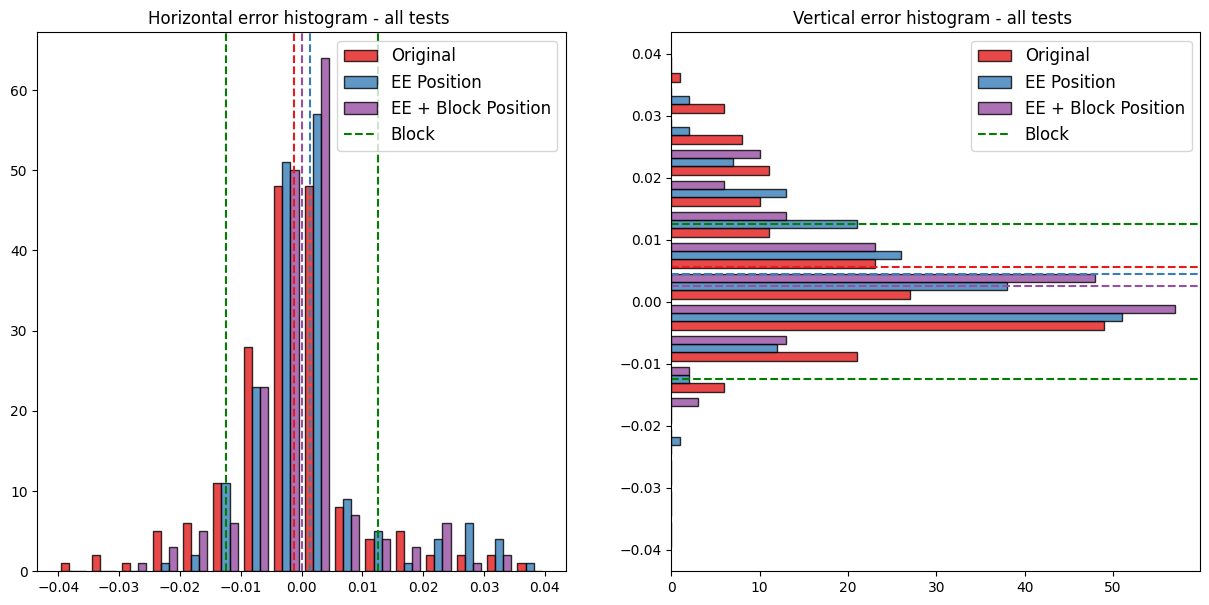

In [47]:
# Define bin width
bin_width = 0.005
########## GENERAL ERROR ANALYSIS ##########
bins = np.arange(-0.04, 0.04+bin_width, bin_width)

d_xy_reshape_og = d_xy_og.transpose(0,2,1).reshape(-1,3)
avg_err_og = [np.mean(d_xy_reshape_og[:, 1]), np.mean(d_xy_reshape_og[:, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_og, axis=1)),3)]
avg_err_success_og = [np.mean(d_xy_reshape_og[success_og == 1, 1]),np.mean(d_xy_reshape_og[success_og == 1, 0]),round(np.mean(np.linalg.norm(d_xy_reshape_og[success_og == 1], axis=1)),3)]
avg_err_failed_og = [np.mean(d_xy_reshape_og[success_og == 0, 1]), np.mean(d_xy_reshape_og[success_og == 0, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_og[success_og == 0], axis=1)),3)]

d_xy_reshape_fk = d_xy_fk.transpose(0,2,1).reshape(-1,3)
avg_err_fk = [np.mean(d_xy_reshape_fk[:, 1]), np.mean(d_xy_reshape_fk[:, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_fk, axis=1)),3)]
avg_err_success_fk = [np.mean(d_xy_reshape_fk[success_fk == 1, 1]), np.mean(d_xy_reshape_fk[success_fk == 1, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_fk[success_fk == 1], axis=1)),3)]
avg_err_failed_fk = [np.mean(d_xy_reshape_fk[success_fk == 0, 1]), np.mean(d_xy_reshape_fk[success_fk == 0, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_fk[success_fk == 0], axis=1)),3)]

d_xy_reshape_dp = d_xy_dp.transpose(0,2,1).reshape(-1,3)
avg_err_dp = [np.mean(d_xy_reshape_dp[:, 1]), np.mean(d_xy_reshape_dp[:, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_dp, axis=1)),3)]
avg_err_success_dp = [np.mean(d_xy_reshape_dp[success_dp == 1, 1]), np.mean(d_xy_reshape_dp[success_dp == 1, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_dp[success_dp == 1], axis=1)),3)]
avg_err_failed_dp = [np.mean(d_xy_reshape_dp[success_dp == 0, 1]), np.mean(d_xy_reshape_dp[success_dp == 0, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_dp[success_dp == 0], axis=1)),3)]

fig_comp_gea, axs_comp_gea = plt.subplots(1,2, figsize=(15, 7))


axs_comp_gea[0].hist([d_xy_og[:,1,:].flatten(),d_xy_fk[:,1,:].flatten(),d_xy_dp[:,1,:].flatten()],label=['Original','EE Position','EE + Block Position'], color=[colors[0], colors[1], colors[3]], stacked = False, bins=bins, alpha = 0.8, edgecolor='black')

axs_comp_gea[0].set_title("Horizontal error histogram - all tests ")
axs_comp_gea[0].axvline(0.0125, color='green', linestyle='--', label='Block')
axs_comp_gea[0].axvline(-0.0125, color='green', linestyle='--')
axs_comp_gea[0].axvline(avg_err_og[0], color=colors[0], linestyle='--')
axs_comp_gea[0].axvline(avg_err_fk[0], color=colors[1], linestyle='--')
axs_comp_gea[0].axvline(avg_err_dp[0], color=colors[3], linestyle='--')
axs_comp_gea[0].legend(fontsize=12)

axs_comp_gea[1].hist([d_xy_og[:,0,:].flatten(),d_xy_fk[:,0,:].flatten(),d_xy_dp[:,0,:].flatten()],label=['Original','EE Position','EE + Block Position'], color=[colors[0], colors[1], colors[3]], stacked = False, bins=bins, alpha = 0.8, edgecolor='black', orientation='horizontal')


axs_comp_gea[1].set_title("Vertical error histogram - all tests ")
axs_comp_gea[1].axhline(0.0125, color='green', linestyle='--')
axs_comp_gea[1].axhline(-0.0125, color='green', linestyle='--', label='Block')
axs_comp_gea[1].axhline(avg_err_og[1], color=colors[0], linestyle='--')
axs_comp_gea[1].axhline(avg_err_fk[1], color=colors[1], linestyle='--')
axs_comp_gea[1].axhline(avg_err_dp[1], color=colors[3], linestyle='--')
axs_comp_gea[1].legend(fontsize=12)

print("average general (h,v): ", avg_err_og,"\n", avg_err_fk,"\n", avg_err_dp)


average unknown (h,v):  [np.float64(-0.0007635816060389034), np.float64(0.009919240598542633), np.float64(0.029)] 
 [np.float64(0.00340415098674621), np.float64(0.009345352330315965), np.float64(0.024)] 
 [np.float64(-2.452605672546047e-05), np.float64(0.005369002814743743), np.float64(0.021)]


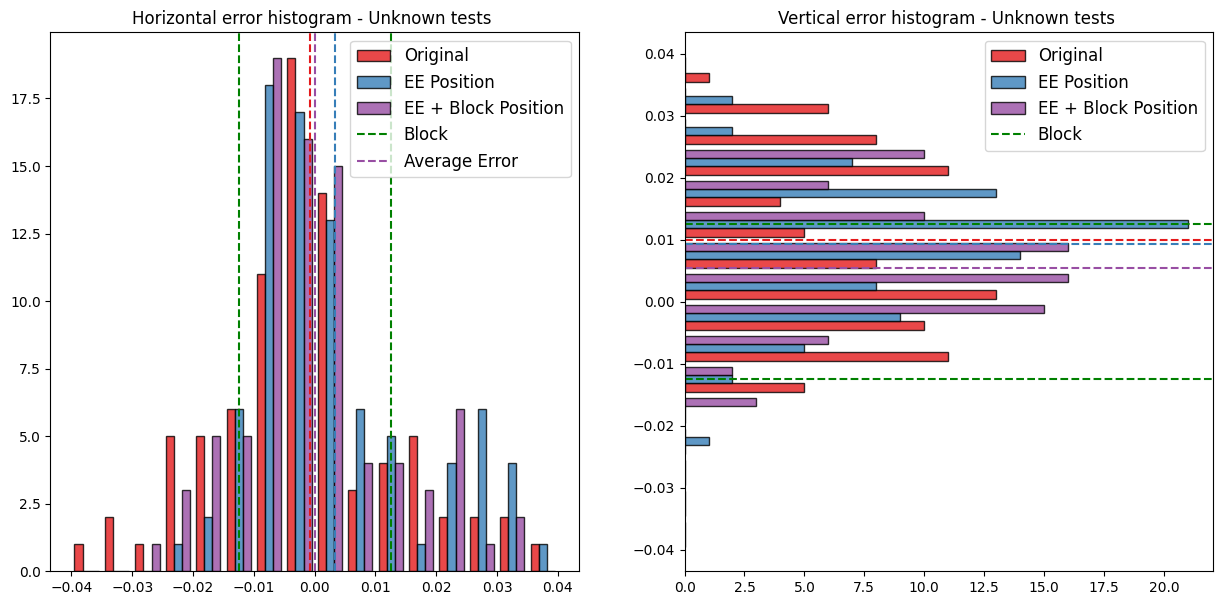

In [48]:
############UNKNOWN ERROR ANALYSIS############
# Define bin width
bins = np.arange(-0.04, 0.04+bin_width, bin_width)
d_xy_unknown_og = d_xy_og[1::2,:,:]  # Select every second episode (unknown)
d_xy_unknown_fk = d_xy_fk[1::2,:,:]  # Select every second episode (unknown)
d_xy_unknown_dp = d_xy_dp[1::2,:,:]  # Select every second episode (unknown)

succ_reshaped_og = success_og.reshape(-1, 7)
selected_groups = succ_reshaped_og[1::2]
succ_unknown_og = selected_groups.reshape(-1)

succ_reshaped_fk = success_fk.reshape(-1, 7)
selected_groups = succ_reshaped_fk[1::2]
succ_unknown_fk = selected_groups.reshape(-1)

succ_reshaped_dp = success_dp.reshape(-1, 7)
selected_groups = succ_reshaped_dp[1::2]
succ_unknown_dp = selected_groups.reshape(-1)

d_xy_reshape_og = d_xy_unknown_og.transpose(0,2,1).reshape(-1,3)
avg_err_unknown_og = [np.mean(d_xy_reshape_og[:, 1]), np.mean(d_xy_reshape_og[:, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_og, axis=1)),3)]
avg_err_success_unknown_og = [np.mean(d_xy_reshape_og[succ_unknown_og == 1, 1]),np.mean(d_xy_reshape_og[succ_unknown_og == 1, 0]),round(np.mean(np.linalg.norm(d_xy_reshape_og[succ_unknown_og == 1], axis=1)),3)]
avg_err_failed_unknown_og = [np.mean(d_xy_reshape_og[succ_unknown_og == 0, 1]), np.mean(d_xy_reshape_og[succ_unknown_og == 0, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_og[succ_unknown_og == 0], axis=1)),3)]

d_xy_reshape_fk = d_xy_unknown_fk.transpose(0,2,1).reshape(-1,3)
avg_err_unknown_fk = [np.mean(d_xy_reshape_fk[:, 1]), np.mean(d_xy_reshape_fk[:, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_fk, axis=1)),3)]
avg_err_success_unknown_fk = [np.mean(d_xy_reshape_fk[succ_unknown_fk == 1, 1]), np.mean(d_xy_reshape_fk[succ_unknown_fk == 1, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_fk[succ_unknown_fk == 1], axis=1)),3)]
avg_err_failed_unknown_fk = [np.mean(d_xy_reshape_fk[succ_unknown_fk == 0, 1]), np.mean(d_xy_reshape_fk[succ_unknown_fk == 0, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_fk[succ_unknown_fk == 0], axis=1)),3)]

d_xy_reshape_dp = d_xy_unknown_dp.transpose(0,2,1).reshape(-1,3)
avg_err_unknown_dp = [np.mean(d_xy_reshape_dp[:, 1]), np.mean(d_xy_reshape_dp[:, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_dp, axis=1)),3)]
avg_err_success_unknown_dp = [np.mean(d_xy_reshape_dp[succ_unknown_dp == 1, 1]), np.mean(d_xy_reshape_dp[succ_unknown_dp == 1, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_dp[succ_unknown_dp == 1], axis=1)),3)]
avg_err_failed_unknown_dp = [np.mean(d_xy_reshape_dp[succ_unknown_dp == 0, 1]), np.mean(d_xy_reshape_dp[succ_unknown_dp == 0, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_dp[succ_unknown_dp == 0], axis=1)),3)]


fig_comp_uea, axs_comp_uea = plt.subplots(1,2, figsize=(15, 7))

axs_comp_uea[0].hist([d_xy_reshape_og[:,1],d_xy_reshape_fk[:,1],d_xy_reshape_dp[:,1]],label=['Original','EE Position','EE + Block Position'], color=[colors[0], colors[1], colors[3]], stacked = False, bins=bins, alpha = 0.8, edgecolor='black')

axs_comp_uea[0].set_title("Horizontal error histogram - Unknown tests ")
axs_comp_uea[0].axvline(0.0125, color='green', linestyle='--', label='Block')
axs_comp_uea[0].axvline(-0.0125, color='green', linestyle='--')
axs_comp_uea[0].axvline(avg_err_unknown_og[0], color=colors[0], linestyle='--')
axs_comp_uea[0].axvline(avg_err_unknown_fk[0], color=colors[1], linestyle='--')
axs_comp_uea[0].axvline(avg_err_unknown_dp[0], color=colors[3], linestyle='--', label='Average Error')
axs_comp_uea[0].legend(fontsize=12)

axs_comp_uea[1].hist([d_xy_reshape_og[:,0],d_xy_reshape_fk[:,0],d_xy_reshape_dp[:,0]],label=['Original','EE Position','EE + Block Position'], color=[colors[0], colors[1], colors[3]], stacked = False, bins=bins, alpha = 0.8, edgecolor='black', orientation='horizontal')

axs_comp_uea[1].set_title("Vertical error histogram - Unknown tests ")
axs_comp_uea[1].axhline(0.0125, color='green', linestyle='--')
axs_comp_uea[1].axhline(-0.0125, color='green', linestyle='--', label='Block')
axs_comp_uea[1].axhline(avg_err_unknown_og[1], color=colors[0], linestyle='--')
axs_comp_uea[1].axhline(avg_err_unknown_fk[1], color=colors[1], linestyle='--')
axs_comp_uea[1].axhline(avg_err_unknown_dp[1], color=colors[3], linestyle='--')
axs_comp_uea[1].legend(fontsize=12)

print("average unknown (h,v): ", avg_err_unknown_og,"\n", avg_err_unknown_fk,"\n", avg_err_unknown_dp)


c:\Users\nduqu\anaconda3\envs\lerobot2\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nduqu\anaconda3\envs\lerobot2\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


average known (h,v):  [np.float64(-0.001542681910312967), np.float64(0.0014942076411185144), np.float64(0.01)] 
 [np.float64(-0.00045312949076589367), np.float64(-6.680375671000339e-05), np.float64(0.007)] 
 [np.float64(7.532798927095227e-05), np.float64(1.8916840947077927e-05), np.float64(0.006)]


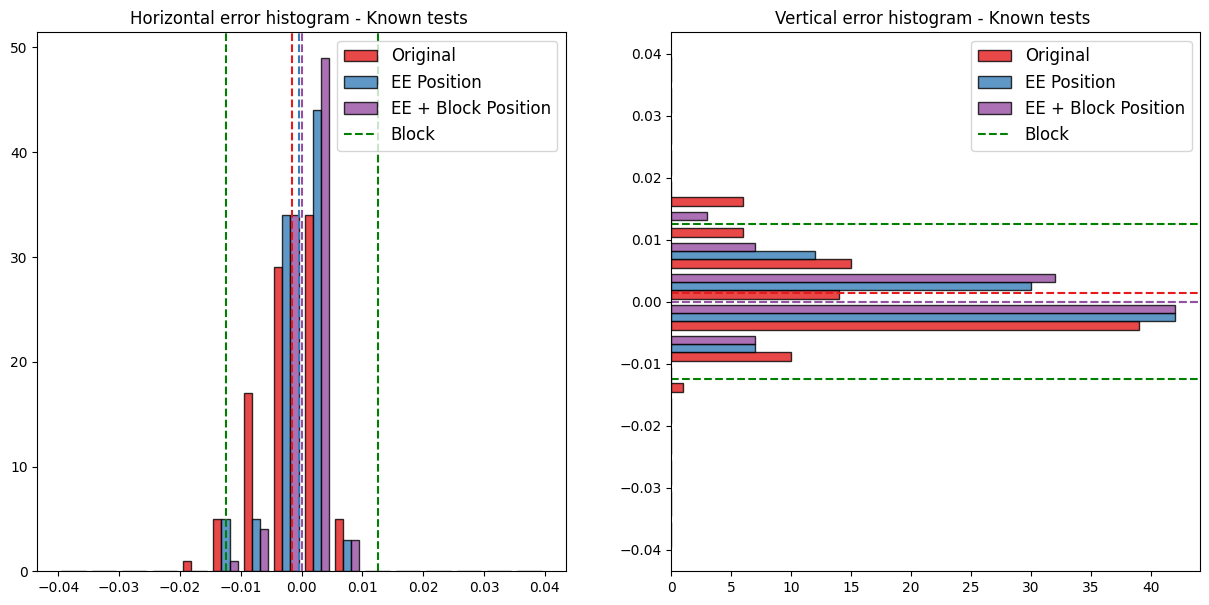

In [49]:
############UNKNOWN ERROR ANALYSIS############
# Define bin width
bins = np.arange(-0.04, 0.04+bin_width, bin_width)
d_xy_known_og = d_xy_og[0::2,:,:]  # Select every second episode (known)
d_xy_known_fk = d_xy_fk[0::2,:,:]  # Select every second episode (known)
d_xy_known_dp = d_xy_dp[0::2,:,:]  # Select every second episode (known)

succ_reshaped_og = success_og.reshape(-1, 7)
selected_groups = succ_reshaped_og[0::2]
succ_known_og = selected_groups.reshape(-1)

succ_reshaped_fk = success_fk.reshape(-1, 7)
selected_groups = succ_reshaped_fk[0::2]
succ_known_fk = selected_groups.reshape(-1)

succ_reshaped_dp = success_dp.reshape(-1, 7)
selected_groups = succ_reshaped_dp[0::2]
succ_known_dp = selected_groups.reshape(-1)

d_xy_reshape_og = d_xy_known_og.transpose(0,2,1).reshape(-1,3)
avg_err_known_og = [np.mean(d_xy_reshape_og[:, 1]), np.mean(d_xy_reshape_og[:, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_og, axis=1)),3)]
avg_err_success_known_og = [np.mean(d_xy_reshape_og[succ_known_og == 1, 1]),np.mean(d_xy_reshape_og[succ_known_og == 1, 0]),round(np.mean(np.linalg.norm(d_xy_reshape_og[succ_known_og == 1], axis=1)),3)]
avg_err_failed_known_og = [np.mean(d_xy_reshape_og[succ_known_og == 0, 1]), np.mean(d_xy_reshape_og[succ_known_og == 0, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_og[succ_known_og == 0], axis=1)),3)]

d_xy_reshape_fk = d_xy_known_fk.transpose(0,2,1).reshape(-1,3)
avg_err_known_fk = [np.mean(d_xy_reshape_fk[:, 1]), np.mean(d_xy_reshape_fk[:, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_fk, axis=1)),3)]
avg_err_success_known_fk = [np.mean(d_xy_reshape_fk[succ_known_fk == 1, 1]), np.mean(d_xy_reshape_fk[succ_known_fk == 1, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_fk[succ_known_fk == 1], axis=1)),3)]
avg_err_failed_known_fk = [np.mean(d_xy_reshape_fk[succ_known_fk == 0, 1]), np.mean(d_xy_reshape_fk[succ_known_fk == 0, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_fk[succ_known_fk == 0], axis=1)),3)]

d_xy_reshape_dp = d_xy_known_dp.transpose(0,2,1).reshape(-1,3)
avg_err_known_dp = [np.mean(d_xy_reshape_dp[:, 1]), np.mean(d_xy_reshape_dp[:, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_dp, axis=1)),3)]
avg_err_success_known_dp = [np.mean(d_xy_reshape_dp[succ_known_dp == 1, 1]), np.mean(d_xy_reshape_dp[succ_known_dp == 1, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_dp[succ_known_dp == 1], axis=1)),3)]
avg_err_failed_known_dp = [np.mean(d_xy_reshape_dp[succ_known_dp == 0, 1]), np.mean(d_xy_reshape_dp[succ_known_dp == 0, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_dp[succ_known_dp == 0], axis=1)),3)]


fig_comp_uea, axs_comp_uea = plt.subplots(1,2, figsize=(15, 7))

axs_comp_uea[0].hist([d_xy_reshape_og[:,1],d_xy_reshape_fk[:,1],d_xy_reshape_dp[:,1]],label=['Original','EE Position','EE + Block Position'], color=[colors[0], colors[1], colors[3]], stacked = False, bins=bins, alpha = 0.8, edgecolor='black')

axs_comp_uea[0].set_title("Horizontal error histogram - Known tests ")
axs_comp_uea[0].axvline(0.0125, color='green', linestyle='--', label='Block')
axs_comp_uea[0].axvline(-0.0125, color='green', linestyle='--')
axs_comp_uea[0].axvline(avg_err_known_og[0], color=colors[0], linestyle='--')
axs_comp_uea[0].axvline(avg_err_known_fk[0], color=colors[1], linestyle='--')
axs_comp_uea[0].axvline(avg_err_known_dp[0], color=colors[3], linestyle='--')
axs_comp_uea[0].legend(fontsize=12)

axs_comp_uea[1].hist([d_xy_reshape_og[:,0],d_xy_reshape_fk[:,0],d_xy_reshape_dp[:,0]],label=['Original','EE Position','EE + Block Position'], color=[colors[0], colors[1], colors[3]], stacked = False, bins=bins, alpha = 0.8, edgecolor='black', orientation='horizontal')

axs_comp_uea[1].set_title("Vertical error histogram - Known tests ")
axs_comp_uea[1].axhline(0.0125, color='green', linestyle='--')
axs_comp_uea[1].axhline(-0.0125, color='green', linestyle='--', label='Block')
axs_comp_uea[1].axhline(avg_err_known_og[1], color=colors[0], linestyle='--')
axs_comp_uea[1].axhline(avg_err_known_fk[1], color=colors[1], linestyle='--')
axs_comp_uea[1].axhline(avg_err_known_dp[1], color=colors[3], linestyle='--')
axs_comp_uea[1].legend(fontsize=12)

print("average known (h,v): ", avg_err_known_og,"\n", avg_err_known_fk,"\n", avg_err_known_dp)




#### Line plot avg ####

In [37]:
import pandas as pd

#fig_comp_line, axs_comp_line = plt.subplots(2, 1, figsize=(15, 10))
l_fs = 22
t_fs = 24
lt_fs = 20

avg_ep_og_eps = np.array(avg_ep_og_eps)
avg_err_og_eps = np.array(avg_err_og_eps)
std_og = np.array(std_og)

avg_ep_fk_eps = np.array(avg_ep_fk_eps)
avg_err_fk_eps = np.array(avg_err_fk_eps)
std_fk = np.array(std_fk)

avg_ep_dp_eps = np.array(avg_ep_dp_eps)
avg_err_dp_eps = np.array(avg_err_dp_eps)
std_dp = np.array(std_dp)

total_grasp = np.stack(total_grasp, axis=0)
print(total_grasp.shape) 

pos = range(1, 26)
'''
for idx, label in enumerate(['vertical', 'horizontal']):
    axs_comp_line[idx].plot(avg_ep_og_eps[:, idx], color=colors[0], marker='o', linestyle='-', linewidth=2, markersize=5, label='Original')
    axs_comp_line[idx].plot(avg_ep_fk_eps[:, idx], color=colors[1], marker='o', linestyle='-', linewidth=2, markersize=5, label='EE Position')
    axs_comp_line[idx].plot(avg_ep_dp_eps[:, idx], color=colors[3], marker='o', linestyle='-', linewidth=2, markersize=5, label='EE + Block Position')
    axs_comp_line[idx].set_xticks(range(25), pos, fontsize=l_fs)
    axs_comp_line[idx].set_xlabel('Training checkpoint', fontsize=l_fs)
    axs_comp_line[idx].set_ylabel('Avg. position [m]', fontsize=l_fs)
    axs_comp_line[idx].set_title(f'Average {label} grasping position per test position', fontsize=t_fs)
    axs_comp_line[idx].legend(fontsize=l_fs)
    boxplot_data = [arr[:,idx] for arr in total_grasp]
    #axs2[idx].boxplot(boxplot_data, vert=True, labels=pos,positions = range(25))
'''
fig_comp_error, axs_comp_error = plt.subplots(2, 1, figsize=(2*lw, 2*lw/1.5))

axs_comp_error[0].plot(avg_err_og_eps[:,0], color=colors[0], marker='o', linestyle='-', linewidth=3, markersize=10, label='Original')
axs_comp_error[0].plot(avg_err_fk_eps[:,0], color=colors[1], marker='o', linestyle='-', linewidth=3, markersize=10, label='EE Position')
axs_comp_error[0].plot(avg_err_dp_eps[:,0], color=colors[3], marker='o', linestyle='-', linewidth=3, markersize=10, label='EE + Block Position')
axs_comp_error[0].axhline(0.0, color='green', marker='None', linestyle='--', linewidth=3, markersize=15)
axs_comp_error[0].set_xticks(range(25),pos)
axs_comp_error[0].tick_params(labelsize=lt_fs)
axs_comp_error[0].set_xlabel('Test position', fontsize=l_fs)
axs_comp_error[0].set_ylabel('Avg. error [m]', fontsize=l_fs)
axs_comp_error[0].set_title('Average vertical grasping position error per test position', fontsize=t_fs)
axs_comp_error[0].legend(fontsize=16)

axs_comp_error[1].plot(avg_err_og_eps[:,1], color=colors[0], marker='o', linestyle='-', linewidth=3, markersize=10, label='Original')
axs_comp_error[1].plot(avg_err_fk_eps[:,1], color=colors[1], marker='o', linestyle='-', linewidth=3, markersize=10, label='EE Position')
axs_comp_error[1].plot(avg_err_dp_eps[:,1], color=colors[3], marker='o', linestyle='-', linewidth=3, markersize=10, label='EE + Block Position')
axs_comp_error[1].axhline(0.0, color='green', marker='o', linestyle='--', linewidth=2, markersize=5)
axs_comp_error[1].set_xticks(range(25),pos)
axs_comp_error[1].tick_params(labelsize=lt_fs)
axs_comp_error[1].set_xlabel('Test position', fontsize=l_fs)
axs_comp_error[1].set_ylabel('Avg. error [m]', fontsize=l_fs)
axs_comp_error[1].set_title('Average horizontal grasping position error per test position', fontsize=t_fs)
axs_comp_error[1].legend(fontsize=16)

fig_comp_error.tight_layout()
fig_comp_error.savefig("pgf/e9_ablation_error_average.pgf")



fig_comp_std, axs_comp_std = plt.subplots(2, 1, figsize=(2*lw, 2*lw/1.5))
ds_values = range(0,25,2)

axs_comp_std[0].plot(std_og[:,0], color=colors[0], marker='o', linestyle='-', linewidth=3, markersize=10, label='Original')
axs_comp_std[0].plot(std_fk[:,0], color=colors[1], marker='o', linestyle='-', linewidth=3, markersize=10, label='EE Position')
axs_comp_std[0].plot(std_dp[:,0], color=colors[3], marker='o', linestyle='-', linewidth=3, markersize=10, label='EE + Block Position')
axs_comp_std[0].plot(ds_values, std_ds[:,0], color='black', marker='x', linestyle='--', linewidth=3, markersize=15, label='Dataset')

axs_comp_std[0].set_xticks(range(25),pos)
axs_comp_std[0].tick_params(labelsize=lt_fs)
axs_comp_std[0].set_xlabel('Test position', fontsize=l_fs)
axs_comp_std[0].set_ylabel('Std. dev [m]', fontsize=l_fs)
axs_comp_std[0].set_title('Average grasping position vertical standard deviation', fontsize=t_fs)
axs_comp_std[0].legend(fontsize=15, loc='upper left')

axs_comp_std[1].plot(std_og[:,1], color=colors[0], marker='o', linestyle='-', linewidth=3, markersize=10, label='Original')
axs_comp_std[1].plot(std_fk[:,1], color=colors[1], marker='o', linestyle='-', linewidth=3, markersize=10, label='EE Position')
axs_comp_std[1].plot(std_dp[:,1], color=colors[3], marker='o', linestyle='-', linewidth=3, markersize=10, label='EE + Block Position')
axs_comp_std[1].plot(ds_values,std_ds[:,1], color='black', marker='x', linestyle='--', linewidth=3, markersize=10, label='Dataset')

axs_comp_std[1].set_xticks(range(25),pos, fontsize=l_fs)
axs_comp_std[1].tick_params(labelsize=lt_fs)
axs_comp_std[1].set_xlabel('Training checkpoint', fontsize=l_fs)
axs_comp_std[1].set_ylabel('Std. dev [m]', fontsize=l_fs)
axs_comp_std[1].set_title('Average grasping position horizontal standard deviation', fontsize=t_fs)
axs_comp_std[1].legend(fontsize=15)

fig_comp_std.tight_layout()
fig_comp_std.savefig("pgf/e9_ablation_error_std_dev.pgf")

std_diff_y_og = np.mean(std_ds[:,0] - std_og[0::2,0])
std_diff_x_og = np.mean(std_ds[:,1] - std_og[0::2,1])

std_y_mean_og = np.mean(std_og[:,0])
std_x_mean_og = np.mean(std_og[:,1])

std_k_y_mean_og = np.mean(std_og[0::2,0])
std_k_x_mean_og = np.mean(std_og[0::2,1])

std_u_y_mean_og = np.mean(std_og[1::2,0])
std_u_x_mean_og = np.mean(std_og[1::2,1])

std_diff_y_fk = np.mean(std_ds[:,0] - std_fk[0::2,0])
std_diff_x_fk = np.mean(std_ds[:,1] - std_fk[0::2,1])
std_y_mean_fk = np.mean(std_fk[:,0])
std_x_mean_fk = np.mean(std_fk[:,1])
std_k_y_mean_fk = np.mean(std_fk[0::2,0])
std_k_x_mean_fk = np.mean(std_fk[0::2,1])
std_u_y_mean_fk = np.mean(std_fk[1::2,0])
std_u_x_mean_fk = np.mean(std_fk[1::2,1])

std_diff_y_dp = np.mean(std_ds[:,0] - std_dp[0::2,0])
std_diff_x_dp = np.mean(std_ds[:,1] - std_dp[0::2,1])
std_y_mean_dp = np.mean(std_dp[:,0])
std_x_mean_dp = np.mean(std_dp[:,1])
std_k_y_mean_dp = np.mean(std_dp[0::2,0])
std_k_x_mean_dp = np.mean(std_dp[0::2,1])
std_u_y_mean_dp = np.mean(std_dp[1::2,0])
std_u_x_mean_dp = np.mean(std_dp[1::2,1])
# Prepare data for the table
data = {
    "Metric": ["std_diff_x", "std_diff_y", "std_x_mean", "std_y_mean", 
               "std_k_x_mean", "std_k_y_mean", "std_u_x_mean", "std_u_y_mean"],
    "OG": [round(std_diff_x_og, 5), round(std_diff_y_og, 5), round(std_x_mean_og, 5), round(std_y_mean_og, 5),
           round(std_k_x_mean_og, 5), round(std_k_y_mean_og, 5), round(std_u_x_mean_og, 5), round(std_u_y_mean_og, 5)],
    "FK": [round(std_diff_x_fk, 5), round(std_diff_y_fk, 5), round(std_x_mean_fk, 5), round(std_y_mean_fk, 5),
           round(std_k_x_mean_fk, 5), round(std_k_y_mean_fk, 5), round(std_u_x_mean_fk, 5), round(std_u_y_mean_fk, 5)],
    "DP": [round(std_diff_x_dp, 5), round(std_diff_y_dp, 5), round(std_x_mean_dp, 5), round(std_y_mean_dp, 5),
           round(std_k_x_mean_dp, 5), round(std_k_y_mean_dp, 5), round(std_u_x_mean_dp, 5), round(std_u_y_mean_dp, 5)]
}

# Create a DataFrame and print it
df = pd.DataFrame(data)
print(df)




(25, 7, 3)
         Metric       OG       FK       DP
0    std_diff_x -0.00102 -0.00050 -0.00040
1    std_diff_y -0.00062 -0.00014 -0.00010
2    std_x_mean  0.00388  0.00394  0.00384
3    std_y_mean  0.00367  0.00354  0.00321
4  std_k_x_mean  0.00265  0.00212  0.00202
5  std_k_y_mean  0.00274  0.00226  0.00221
6  std_u_x_mean  0.00522  0.00591  0.00581
7  std_u_y_mean  0.00469  0.00493  0.00428
